<a href="https://colab.research.google.com/github/Hubert26/machine-learning/blob/data-exp/project_hubert_szewczyk.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#OPIS PROJEKTU

Lending Club to firma pożyczkowa typu peer-to-peer, która łączy pożyczkobiorców z
inwestorami za pośrednictwem platformy internetowej. Obsługuje osoby, które potrzebują
pożyczek osobistych w wysokości od 1000 do 40 000 USD. Pożyczkobiorcy otrzymują pełną
kwotę udzielonej pożyczki pomniejszoną o opłatę początkową, która jest uiszczana firmie.
Inwestorzy kupują weksle zabezpieczone osobistymi pożyczkami i płacą Lending Club
opłatę za usługę. Firma Lending Club udostępnia dane o wszystkich pożyczkach
udzielonych za pośrednictwem swojej platformy w określonych okresach.
Na potrzeby tego projektu zostały użyte dane dotyczące pożyczek udzielonych za
pośrednictwem Lending Club na przestrzeni lat 2007 -2011. Każda pożyczka jest opatrzona
informacją o tym, czy ostatecznie została spłacona (Fully Paid lub Charged off w kolumnie
loan_status).

W tym projekcie chcę zbudować model klasyfikacyjny, który na podstawie zebranych danych będzie przewidywał, czy potencjalny pozyczkobiorca spłaci swój dług.

#KOD

##Import bibliotek i ustawienia

In [1]:
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
import time
from scipy.stats import chi2_contingency
from scipy.stats import chi2
from sklearn.preprocessing import LabelEncoder
from datetime import datetime


from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report



#Ustawienie braku maksymalnej ilości wyświetlanych kolumn
pd.options.display.max_columns = None

#!pip install -q --upgrade plotly
import plotly
import plotly.graph_objects as go
import plotly.express as px
import plotly.figure_factory as ff
print(plotly.__version__)

np.random.seed(42)

5.15.0


##Definicje funkcji

####display_info

In [2]:
def display_info(df, selected_columns, df_info):
    print(selected_columns)
    print(len(selected_columns))
    for col_name in selected_columns:
        print("Column Name:", col_name)

        # Description
        if col_name in df_info.index:
            print("Description:", df_info.loc[col_name]['Description'])
        else:
            print("Description not available.")

        # Statistics
        print("\nStatistics:")
        print(df[col_name].describe())

        # Mode
        print("\nMode:")
        print(df[col_name].mode())

        # NaN count
        nan_count = df[col_name].isna().sum()
        print("\nNaN count:", nan_count)

        # Unique values len
        print("\nUnique values len:")
        print(len(df[col_name].unique()))

        # Unique values
        print("\nUnique values:")
        print(df[col_name].unique())

        # Value counts
        print("\nValue counts:")
        print(df[col_name].value_counts())

        print("\n" + "=" * 40)  # Separator between columns

####nan_counts

In [3]:
def nan_counts(df, min_nan, max_nan):
    mask = df.isna()
    nan_counts_columns = mask.sum()
    naan_column = pd.DataFrame(nan_counts_columns, columns=['NaN'])
    selected_columns = [col_name for col_name in naan_column.index if min_nan <= naan_column.at[col_name, 'NaN'] <= max_nan]

    #display(naan_column.loc[:])
    return selected_columns

####unique_counts

In [4]:
def unique_counts(df, min_unique=0, max_unique=None):

    unique_counts_columns = df.nunique()
    unique_column = pd.DataFrame(unique_counts_columns, columns=['Unique'])
    selected_columns = [col_name for col_name, unique_count in unique_column.iterrows()
                        if min_unique <= unique_count['Unique'] and (max_unique is None or unique_count['Unique'] <= max_unique)]

    return selected_columns

####diff_counts

In [5]:
def diff_counts(df, min_diff, max_diff):
  unique_value_counts = {}
  for col_name in df.columns.tolist():
      unique_value_counts[col_name] = df[col_name].value_counts()

  #Obliczenie różnicy między liczbami wystąpień unikalnych wartości w kolumnach
  value_count_differences = pd.DataFrame(index=df.columns.tolist(), columns=['diff'])
  for col_name, counts in unique_value_counts.items():
  # Sortowanie wartości występujących w danej kolumnie malejąco
      sorted_counts = counts.sort_values(ascending=False)

      # Sprawdzanie, czy są przynajmniej dwie różne wartości
      if len(sorted_counts) >= 2:
          diff = sorted_counts.iloc[0] - sorted_counts.iloc[1]
          value_count_differences.at[col_name, 'diff'] = diff
      else:
          value_count_differences.at[col_name, 'diff'] = 0  # Jeśli jest mniej niż dwie różne wartości, to różnica wynosi 0

  selected_columns = value_count_differences.index[
      (value_count_differences['diff'] >= min_diff) &
       (value_count_differences['diff'] <= max_diff)].tolist()
  return selected_columns


####chi2_test

In [6]:
def chi2_test(col, col2='loan_status', norm=0):
    if norm==1:
      data_cross = pd.crosstab(df[col], df[col2], margins=False, normalize='columns')
    else:
      data_cross = pd.crosstab(df[col], df[col2], margins=False)
    display(data_cross)
    chi2_stat, p, dof, expected = chi2_contingency(data_cross)
    alpha = 0.05
    print("chi2: " + str(chi2_stat))
    print("p value: " + str(p))
    prob = 0.95
    critical = chi2.ppf(prob, dof)
    if abs(chi2_stat) >= critical:
        print('Dependent (reject H0)')
    else:
        print('Independent (fail to reject H0)')

####find_correlation_pairs

In [7]:
def find_correlation_pairs(correlation_df, min_corr, max_corr):
    corr_pairs = correlation_df[(abs(correlation_df) > min_corr) & (abs(correlation_df) < max_corr)]

    corr_pairs_df = pd.DataFrame(columns=['column1', 'column2', 'correlation'])

    added_pairs = []

    for index, column in corr_pairs.stack().items():
        if not pd.isna(column):
            pair = (index[0], index[1])
            reverse_pair = (index[1], index[0])

            if pair not in added_pairs and reverse_pair not in added_pairs:
                temp_df = pd.DataFrame({'column1': [index[0]], 'column2': [index[1]], 'correlation': [column]})
                added_pairs.append(pair)
                corr_pairs_df = pd.concat([corr_pairs_df, temp_df], ignore_index=True)

    return corr_pairs_df

####find_outliers

In [8]:
def find_outliers(df):
    # Obliczenie kwantyli i IQR tylko dla kolumn numerycznych
    Q1 = df.quantile(0.25, numeric_only=True)
    Q3 = df.quantile(0.75, numeric_only=True)
    IQR = Q3 - Q1

    # Obliczenie granic tylko dla kolumn numerycznych
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Zliczanie wartości odstających tylko dla kolumn numerycznych
    outliers_count = ((df.select_dtypes(include='number') < lower_bound) | (df.select_dtypes(include='number') > upper_bound)).sum()

    # Tworzenie DataFrame z wynikami
    data_outliers = pd.DataFrame({'Q1': Q1, 'Q3': Q3, 'IQR': IQR,
                                  'lower_bound': lower_bound,
                                  'upper_bound': upper_bound,
                                  'outliers_count': outliers_count})

    return data_outliers

####plot_confusion_matrix

In [9]:
def plot_confusion_matrix(cm, model):
    # klasyfikacja binarna
    cm = cm[::-1]
    cm = pd.DataFrame(cm, columns=['pred_0', 'pred_1'], index=['true_1', 'true_0'])

    fig = ff.create_annotated_heatmap(z=cm.values, x=list(cm.columns), y=list(cm.index),
                                      colorscale='ice', showscale=True, reversescale=True)
    fig.update_layout(
        width=500,
        height=500,
        title=model+' Confusion Matrix',
        font_size=16,
        template='plotly_dark'
        )
    fig.show()

####plot_roc_curve
 Receiver Operating Characteristic
1. True Positive Rate (TPR) = FP / (FP+TN)
2. False Positive Rate (FPR) = TP / (TP+FN)

In [10]:
def plot_roc_curve(y_test, y_pred, model):
    # Binary classification
    from sklearn.metrics import roc_curve
    fpr, tpr, tresh = roc_curve(y_test, y_pred, pos_label=1)

    fig = go.Figure(
        data=[
            go.Scatter(x=fpr, y=tpr,
                    line_color='red',
                    name='ROC Curve'),
            go.Scatter(x=[0, 1], y=[0, 1],
                    mode='lines',
                    line_dash='dash',
                    line_color='#F012BE')
        ],
        layout=go.Layout(xaxis_title='False Positive Rate',
                         yaxis_title='True Positive Rate',
                         title = model + ' ROC Curve',
                         showlegend=False,
                         template='plotly_dark',
                         width=700))
    fig.show()


####model_validation


Precision (precyzja) = TP / (TP+FP): Ile obserwacji przewidzianych jako pozytywne jest w rzeczywistości pozytywne.

Recall (czułość) = TP / (TP+FN): Ile obserwacji z wszystkich pozywtywnych sklasyfikowaliśmy jako pozytywne.

F1-score: ważona średnia harmonicza między precyzją a czułością;

Support (wsparcie): liczba próbek, które należą do każdej z klas;

Accuracy (dokładność) = (TP+TN) /(TP+TN+FP+FN))

FPR (False Positive Rate) = FP / (FP+TN) [type I error]

FNR (False Negative Rate) = FN / (FN+TP) [type II error]

In [11]:
def model_validation(y_test, y_pred, model):
  from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

  accuracy = accuracy_score(y_test, y_pred)
  precision = precision_score(y_test, y_pred, average="weighted")
  recall = recall_score(y_test, y_pred, average="weighted")
  f1 = f1_score(y_test, y_pred, average="weighted")
  roc_score = roc_auc_score(y_test, y_pred)
  cm = confusion_matrix(y_test, y_pred)
  tn, fp, fn, tp = cm.ravel()
  fpr = fp / (fp + tn) # False Positive Rate - Type I error
  fnr = fn / (fn + tp) # False Negative Rate - Type II error

  model_results = pd.DataFrame([{'accuracy': accuracy,
                                 'precision': precision,
                                 'recall': recall,
                                 'f1': f1,
                                 'AUROC': roc_score,
                                 'fpr': fpr,
                                 'fnr': fnr
                                 }],
                                  index=[str(model)]
                               )
  return model_results

##1. Obróbka danych

###Pobranie danych z plików

In [12]:
df_raw = pd.read_csv('https://raw.githubusercontent.com/Hubert26/machine-learning/main/Loan_data.csv', low_memory=False)

In [13]:
df = df_raw.copy()

In [14]:
df_info_raw = pd.read_csv('https://raw.githubusercontent.com/Hubert26/machine-learning/main/LCDataDictionary.csv')

In [15]:
df_info = df_info_raw.iloc[:, 0:2]
df_info.set_index(df_info.columns.tolist()[0], inplace=True)

###Eksploracja danych

In [16]:
df.shape

(42536, 151)

In [17]:
df.head(2)

id  member_id  loan_amnt  funded_amnt  funded_amnt_inv        term  \
0  1077501        NaN     5000.0       5000.0           4975.0   36 months   
1  1077430        NaN     2500.0       2500.0           2500.0   60 months   

  int_rate  installment grade sub_grade emp_title emp_length home_ownership  \
0   10.65%       162.87     B        B2       NaN  10+ years           RENT   
1   15.27%        59.83     C        C4     Ryder   < 1 year           RENT   

   annual_inc verification_status   issue_d  loan_status pymnt_plan  \
0     24000.0            Verified  Dec-2011   Fully Paid          n   
1     30000.0     Source Verified  Dec-2011  Charged Off          n   

                                                 url  \
0  https://lendingclub.com/browse/loanDetail.acti...   
1  https://lendingclub.com/browse/loanDetail.acti...   

                                                desc      purpose     title  \
0    Borrower added on 12/22/11 > I need to upgra...  credit_card  Computer   
1    Borrower added on 12/22/11 > I plan to use t...          car      bike   

  zip_code addr_state    dti  delinq_2yrs earliest_cr_line  fico_range_low  \
0    860xx         AZ  27.65          0.0         Jan-1985           735.0   
1    309xx         GA   1.00          0.0         Apr-1999           740.0   

   fico_range_high  inq_last_6mths  mths_since_last_delinq  \
0            739.0             1.0                     NaN   
1            744.0             5.0                     NaN   

   mths_since_last_record  open_acc  pub_rec  revol_bal revol_util  total_acc  \
0                     NaN       3.0      0.0    13648.0      83.7%        9.0   
1                     NaN       3.0      0.0     1687.0       9.4%        4.0   

  initial_list_status  out_prncp  out_prncp_inv  total_pymnt  total_pymnt_inv  \
0                   f        0.0            0.0  5863.155187          5833.84   
1                   f        0.0            0.0  1014.530000          1014.53   

   total_rec_prncp  total_rec_int  total_rec_late_fee  recoveries  \
0          5000.00         863.16                 0.0         0.0   
1           456.46         435.17                 0.0       122.9   

   collection_recovery_fee last_pymnt_d  last_pymnt_amnt next_pymnt_d  \
0                     0.00     Jan-2015           171.62          NaN   
1                     1.11     Apr-2013           119.66          NaN   

  last_credit_pull_d  last_fico_range_high  last_fico_range_low  \
0           Aug-2018                 739.0                735.0   
1           Oct-2016                 499.0                  0.0   

   collections_12_mths_ex_med  mths_since_last_major_derog  policy_code  \
0                         0.0                          NaN          1.0   
1                         0.0                          NaN          1.0   

  application_type  annual_inc_joint  dti_joint  verification_status_joint  \
0       Individual               NaN        NaN                        NaN   
1       Individual               NaN        NaN                        NaN   

   acc_now_delinq  tot_coll_amt  tot_cur_bal  open_acc_6m  open_act_il  \
0             0.0           NaN          NaN          NaN          NaN   
1             0.0           NaN          NaN          NaN          NaN   

   open_il_12m  open_il_24m  mths_since_rcnt_il  total_bal_il  il_util  \
0          NaN          NaN                 NaN           NaN      NaN   
1          NaN          NaN                 NaN           NaN      NaN   

   open_rv_12m  open_rv_24m  max_bal_bc  all_util  total_rev_hi_lim  inq_fi  \
0          NaN          NaN         NaN       NaN               NaN     NaN   
1          NaN          NaN         NaN       NaN               NaN     NaN   

   total_cu_tl  inq_last_12m  acc_open_past_24mths  avg_cur_bal  \
0          NaN           NaN                   NaN          NaN   
1          NaN           NaN                   NaN          NaN   

   bc_open_to_buy  bc_util 

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42536 entries, 0 to 42535
Columns: 151 entries, id to settlement_term
dtypes: float64(120), object(31)
memory usage: 49.0+ MB


In [19]:
df.describe()

member_id     loan_amnt   funded_amnt  funded_amnt_inv   installment  \
count        0.0  42535.000000  42535.000000     42535.000000  42535.000000   
mean         NaN  11089.722581  10821.585753     10139.938785    322.623063   
std          NaN   7410.938391   7146.914675      7131.598014    208.927216   
min          NaN    500.000000    500.000000         0.000000     15.670000   
25%          NaN   5200.000000   5000.000000      4950.000000    165.520000   
50%          NaN   9700.000000   9600.000000      8500.000000    277.690000   
75%          NaN  15000.000000  15000.000000     14000.000000    428.180000   
max          NaN  35000.000000  35000.000000     35000.000000   1305.190000   

         annual_inc           dti   delinq_2yrs  fico_range_low  \
count  4.253100e+04  42535.000000  42506.000000    42535.000000   
mean   6.913656e+04     13.373043      0.152449      713.052545   
std    6.409635e+04      6.726315      0.512406       36.188439   
min    1.896000e+03      0.000000      0.000000      610.000000   
25%    4.000000e+04      8.200000      0.000000      685.000000   
50%    5.900000e+04     13.470000      0.000000      710.000000   
75%    8.250000e+04     18.680000      0.000000      740.000000   
max    6.000000e+06     29.990000     13.000000      825.000000   

       fico_range_high  inq_last_6mths  mths_since_last_delinq  \
count     42535.000000    42506.000000            15609.000000   
mean        717.052545        1.081424               35.017618   
std          36.188439        1.527455               22.418427   
min         614.000000        0.000000                0.000000   
25%         689.000000        0.000000               17.000000   
50%         714.000000        1.000000               33.000000   
75%         744.000000        2.000000               51.000000   
max         829.000000       33.000000              120.000000   

       mths_since_last_record      open_acc       pub_rec     revol_bal  \
count             3651.000000  42506.000000  42506.000000  4.253500e+04   
mean                59.175568      9.343951      0.058156  1.429786e+04   
std                 47.145396      4.496274      0.245713  2.201844e+04   
min                  0.000000      1.000000      0.000000  0.000000e+00   
25%                  0.000000      6.000000      0.000000  3.635000e+03   
50%                 85.000000      9.000000      0.000000  8.821000e+03   
75%                101.000000     12.000000      0.000000  1.725100e+04   
max                129.000000     47.000000      5.000000  1.207359e+06   

          total_acc  out_prncp  out_prncp_inv   total_pymnt  total_pymnt_inv  \
count  42506.000000    42535.0        42535.0  42535.000000     42535.000000   
mean      22.124406        0.0            0.0  12020.189644     11312.729377   
std       11.592811        0.0            0.0   9094.685888      9038.506549   
min        1.000000        0.0            0.0      0.000000         0.000000   
25%       13.000000        0.0            0.0   5465.685189      4793.115000   
50%       20.000000        0.0            0.0   9682.251696      8956.080000   
75%       29.000000        0.0            0.0  16427.850066     15543.875000   
max       90.000000        0.0            0.0  58886.473429     58563.680000   

       total_rec_prncp  total_rec_int  total_rec_late_fee    recoveries  \
count     42535.000000   42535.000000        42535.000000  42535.000000   
mean       9675.675936    2239.981444            1.516890    103.015467   
std        7105.750304    2585.057393            7.830064    735.799086   
min           0.000000       0.000000            0.000000      0.000000   
25%        4400.000000     657.100000            0.000000      0.000000   
50%        8000.000000    1339.160000            0.000000      0.000000   
75%       13499.995000    2803.090000            0.000000      0.000000   
max       35000.020000   23886.470000          209.000000  29623.350000   

       collection_recov

In [20]:
df[df['id'].duplicated()].id #Sprawdzenie duplikatów

Series([], Name: id, dtype: object)

In [21]:
df_info

Description
LoanStatNew                                                             
acc_now_delinq         The number of accounts on which the borrower i...
acc_open_past_24mths          Number of trades opened in past 24 months.
addr_state             The state provided by the borrower in the loan...
all_util                           Balance to credit limit on all trades
annual_inc             The self-reported annual income provided by th...
...                                                                  ...
settlement_amount      The loan amount that the borrower has agreed t...
settlement_percentage  The settlement amount as a percentage of the p...
settlement_term        The number of months that the borrower will be...
NaN                                                                  NaN
NaN                    * Employer Title replaces Employer Name for al...

[153 rows x 1 columns]

In [22]:
##Brakujące dane
total = df.isnull().sum().sort_values(ascending=False)
percent = 100*(df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

Total  Percent
inq_fi                          42536    100.0
mths_since_recent_revol_delinq  42536    100.0
open_acc_6m                     42536    100.0
tot_cur_bal                     42536    100.0
tot_coll_amt                    42536    100.0
mths_since_recent_bc_dlq        42536    100.0
verification_status_joint       42536    100.0
dti_joint                       42536    100.0
annual_inc_joint                42536    100.0
mths_since_recent_inq           42536    100.0
mths_since_last_major_derog     42536    100.0
open_il_12m                     42536    100.0
num_accts_ever_120_pd           42536    100.0
num_actv_bc_tl                  42536    100.0
num_actv_rev_tl                 42536    100.0
num_bc_sats                     42536    100.0
num_bc_tl                       42536    100.0
num_il_tl                       42536    100.0
num_op_rev_tl                   42536    100.0
num_rev_accts                   42536    100.0

In [23]:
column_names = df.columns.tolist()

###Wyświetlenie Loan Status

Charged Off to status długu uznawanego za nieściągalny po 180 dniach braku płatności, ale nie oznacza umorzenia długu. Odpisanie długu wpływa negatywnie na historię kredytową i zdolność kredytową pożyczkobiorcy. Mimo spłaty długu, status Charged Off pozostaje w raporcie kredytowym przez siedem lat, choć może zostać zmieniony na "odpis opłacony" lub "odpis rozliczony". W praktyce, wiele osób spłaciło dług, ale nadal ma status Charged Off.

In [24]:
df_info.loc["settlement_status"]['Description']

'The status of the borrower’s settlement plan. Possible values are: COMPLETE, ACTIVE, BROKEN, CANCELLED, DENIED, DRAFT'

In [25]:
df.settlement_status.unique()

array([nan, 'COMPLETE', 'BROKEN', 'ACTIVE'], dtype=object)

In [26]:
df_info.loc["loan_status"]['Description']

'Current status of the loan'

In [27]:
df.loan_status.unique()

array(['Fully Paid', 'Charged Off', nan,
       'Does not meet the credit policy. Status:Fully Paid',
       'Does not meet the credit policy. Status:Charged Off'],
      dtype=object)

In [28]:
df["loan_status"] = df["loan_status"].replace(
    {"Does not meet the credit policy. Status:Fully Paid": "Fully Paid",
     "Does not meet the credit policy. Status:Charged Off": "Charged Off"})

In [29]:
df[(df.loan_status == 'Charged Off') & (df.settlement_status == "COMPLETE")].shape[0]

142

Wynika z tego, że są 142 wyniki z loan_status == Charged Off wraz z settlement_status == COMPLETE.

W dalszej części zmieniamy wynik Charged Off na Fully Paid dla takich wpisów.

In [30]:
df.loc[df['settlement_status'] == "COMPLETE", 'loan_status'] = "Fully Paid"

In [31]:
df['loan_status'].value_counts()

Fully Paid     36246
Charged Off     6289
Name: loan_status, dtype: int64

###Usunięcie kolumn które zawierają informacje z przyszłości, niedostępne w momencie udzielania pożyczki

In [32]:
future_data = df[["mths_since_last_delinq", "last_pymnt_d",
                      "collection_recovery_fee", "recoveries", "issue_d",
                      "total_rec_late_fee", "total_rec_prncp", "funded_amnt",
                      "funded_amnt_inv", "last_fico_range_high",
                      "last_fico_range_low", "debt_settlement_flag"]]
selected_columns = future_data.columns
df.drop(columns=selected_columns, inplace=True, axis=1, errors='ignore')

###Usunięcie kolumn ze zbędnymi informacjami

####Usunięcie kolumn które mają ponad 90% wartości NaN

In [33]:
selected_columns = nan_counts(df,0.9*df.shape[0], df.shape[0])
display_info(df, selected_columns, df_info)
df.drop(selected_columns, inplace=True, axis=1, errors='ignore')

['member_id', 'mths_since_last_record', 'next_pymnt_d', 'mths_since_last_major_derog', 'annual_inc_joint', 'dti_joint', 'verification_status_joint', 'tot_coll_amt', 'tot_cur_bal', 'open_acc_6m', 'open_act_il', 'open_il_12m', 'open_il_24m', 'mths_since_rcnt_il', 'total_bal_il', 'il_util', 'open_rv_12m', 'open_rv_24m', 'max_bal_bc', 'all_util', 'total_rev_hi_lim', 'inq_fi', 'total_cu_tl', 'inq_last_12m', 'acc_open_past_24mths', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util', 'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 'mort_acc', 'mths_since_recent_bc', 'mths_since_recent_bc_dlq', 'mths_since_recent_inq', 'mths_since_recent_revol_delinq', 'num_accts_ever_120_pd', 'num_actv_bc_tl', 'num_actv_rev_tl', 'num_bc_sats', 'num_bc_tl', 'num_il_tl', 'num_op_rev_tl', 'num_rev_accts', 'num_rev_tl_bal_gt_0', 'num_sats', 'num_tl_120dpd_2m', 'num_tl_30dpd', 'num_tl_90g_dpd_24m', 'num_tl_op_past_12m', 'pct_tl_nvr_dlq', 'percent_bc_gt_75', 'tot_hi_cred_lim', 'tota

####Usunięcie kolumn o: jednej unikalnej wartości, ilości NaN > 1/4 ilości wierszy

In [34]:
selected_columns = list(set(unique_counts(df, 0, 1)) &
                        set(nan_counts(df, 0, 0.25*df.shape[0])) &
                        set(diff_counts(df, 0, df.shape[0])))
display_info(df, selected_columns, df_info)

df.drop(selected_columns, inplace=True, axis=1, errors='ignore')

['policy_code', 'initial_list_status', 'collections_12_mths_ex_med', 'pymnt_plan', 'chargeoff_within_12_mths', 'out_prncp_inv', 'out_prncp', 'disbursement_method', 'application_type', 'hardship_flag']
10
Column Name: policy_code
Description: publicly available policy_code=1
new products not publicly available policy_code=2

Statistics:
count    42535.0
mean         1.0
std          0.0
min          1.0
25%          1.0
50%          1.0
75%          1.0
max          1.0
Name: policy_code, dtype: float64

Mode:
0    1.0
Name: policy_code, dtype: float64

NaN count: 1

Unique values len:
2

Unique values:
[ 1. nan]

Value counts:
1.0    42535
Name: policy_code, dtype: int64

Column Name: initial_list_status
Description: The initial listing status of the loan. Possible values are – W, F

Statistics:
count     42535
unique        1
top           f
freq      42535
Name: initial_list_status, dtype: object

Mode:
0    f
Name: initial_list_status, dtype: object

NaN count: 1

Unique values len:

###Analiza brakujących wartości wraz z ich uzupełnieniem/usunięciem przy wzięciu pod uwagę pewnych ustalonych kryteriów

####Usunięcie kolumn o: dużej ilości unikalnych wartości, typu != float64

In [35]:
selected_columns = list(set(unique_counts(df, 0.1*df.shape[0], df.shape[0])) &
                        set(nan_counts(df, 0, df.shape[0])) &
                        set(diff_counts(df, 0, df.shape[0]))&
                        set([col for col in df.columns if df[col].dtype != 'float64']))

display_info(df, selected_columns, df_info)

if selected_columns:
  df.drop(selected_columns, inplace=True, axis=1, errors='ignore')

['emp_title', 'id', 'desc', 'url', 'title']
5
Column Name: emp_title
Description: The job title supplied by the Borrower when applying for the loan.*

Statistics:
count       39909
unique      30658
top       US Army
freq          139
Name: emp_title, dtype: object

Mode:
0    US Army
Name: emp_title, dtype: object

NaN count: 2627

Unique values len:
30659

Unique values:
[nan 'Ryder' 'AIR RESOURCES BOARD' ... 'Tanks Tavern'
 'Halping hands company inc.' 'Homemaker']

Value counts:
US Army                             139
Bank of America                     115
IBM                                  72
Kaiser Permanente                    61
AT&T                                 61
                                   ... 
Regional Elite Airlines Services      1
Mass General Medical Group            1
Kontera                               1
Southeast Georgia Health ystem        1
Homemaker                             1
Name: emp_title, Length: 30658, dtype: int64

Column Name: id
Descriptio

####Uzupełnienie modą kolumn o: małej ilości NaN

In [36]:
selected_columns = list(set(unique_counts(df, 1, df.shape[0])) &
                        set(nan_counts(df, 1, 0.01*df.shape[0])) &
                        set(diff_counts(df, 0, df.shape[0])))

display_info(df, selected_columns, df_info)
if selected_columns:
  df.loc[:, selected_columns] = df[selected_columns].fillna(df[selected_columns].mode().iloc[0])

['acc_now_delinq', 'zip_code', 'grade', 'home_ownership', 'delinq_2yrs', 'total_pymnt', 'int_rate', 'addr_state', 'total_pymnt_inv', 'total_rec_int', 'fico_range_high', 'inq_last_6mths', 'sub_grade', 'term', 'earliest_cr_line', 'last_credit_pull_d', 'loan_status', 'delinq_amnt', 'purpose', 'annual_inc', 'revol_bal', 'total_acc', 'loan_amnt', 'pub_rec', 'open_acc', 'revol_util', 'verification_status', 'installment', 'dti', 'fico_range_low', 'last_pymnt_amnt', 'tax_liens']
32
Column Name: acc_now_delinq
Description: The number of accounts on which the borrower is now delinquent.

Statistics:
count    42506.000000
mean         0.000094
std          0.009700
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: acc_now_delinq, dtype: float64

Mode:
0    0.0
Name: acc_now_delinq, dtype: float64

NaN count: 30

Unique values len:
3

Unique values:
[ 0. nan  1.]

Value counts:
0.0    42502
1.0        4
Name: acc_now_delinq, dtype: 

####Uzupełnienie modą kolumn o: dużej ilości NaN,  małej ilości unikalnych wartości, małej róznicy między wartościami
Można się zastanowić nad uzupełnieniem danych wdł rozkładu

In [37]:
selected_columns = list(set(unique_counts(df, 0, 0.01*df.shape[0])) &
                        set(nan_counts(df, 0.01*df.shape[0], df.shape[0])) &
                        set(diff_counts(df, 1, 0.2*df.shape[0])))

display_info(df, selected_columns, df_info)

if selected_columns:
  df.loc[:, selected_columns] = df[selected_columns].fillna(df[selected_columns].mode().iloc[0])

['emp_length']
1
Column Name: emp_length
Description: Employment length in years. Possible values are between 0 and 10 where 0 means less than one year and 10 means ten or more years. 

Statistics:
count         41423
unique           11
top       10+ years
freq           9369
Name: emp_length, dtype: object

Mode:
0    10+ years
Name: emp_length, dtype: object

NaN count: 1113

Unique values len:
12

Unique values:
['10+ years' '< 1 year' '1 year' '3 years' '8 years' '9 years' '4 years'
 '5 years' '6 years' '2 years' '7 years' nan]

Value counts:
10+ years    9369
< 1 year     5062
2 years      4743
3 years      4364
4 years      3649
1 year       3595
5 years      3458
6 years      2375
7 years      1875
8 years      1592
9 years      1341
Name: emp_length, dtype: int64



####Usunięcie kolumn o: dużej ilości NaN, dużej ilości unikalnych wartości, małej róznicy między wartościami

In [38]:
selected_columns = list(set(unique_counts(df, 0.1*df.shape[0], df.shape[0])) &
                        set(nan_counts(df, 0.01*df.shape[0], df.shape[0])) &
                        set(diff_counts(df, 1, 0.2*df.shape[0])))

display_info(df, selected_columns, df_info)

if selected_columns:
  df.drop(selected_columns, inplace=True, axis=1, errors='ignore')

[]
0


####Uzupełnienie modą kolumn o: dużej ilości NaN,dowolnej ilości unikalnych wartości, dowolnej róznicy między wartościami

In [39]:
selected_columns = list(set(unique_counts(df, 0, df.shape[0])) &
                        set(nan_counts(df, 0.01*df.shape[0], df.shape[0])) &
                        set(diff_counts(df, 0, df.shape[0])))

display_info(df, selected_columns, df_info)

if selected_columns:
  df.loc[:, selected_columns] = df[selected_columns].fillna(df[selected_columns].mode().iloc[0])

['pub_rec_bankruptcies']
1
Column Name: pub_rec_bankruptcies
Description: Number of public record bankruptcies

Statistics:
count    41170.000000
mean         0.045227
std          0.208737
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          2.000000
Name: pub_rec_bankruptcies, dtype: float64

Mode:
0    0.0
Name: pub_rec_bankruptcies, dtype: float64

NaN count: 1366

Unique values len:
4

Unique values:
[ 0.  1.  2. nan]

Value counts:
0.0    39316
1.0     1846
2.0        8
Name: pub_rec_bankruptcies, dtype: int64



###Przekształcenie wartości w kolumnach - usunięcie procentów, dodatkowych znaków, itd

In [40]:
#Numeric
df["revol_util"] = df["revol_util"].str[0:-1].astype(np.float64)
df["int_rate"] = df["int_rate"].str[0:-1].astype(np.float64)

#Date
df['last_credit_pull_d'] = pd.to_datetime(df['last_credit_pull_d'], errors='coerce')
df['earliest_cr_line'] = pd.to_datetime(df['earliest_cr_line'], errors='coerce')

df['last_credit_pull_d_year'] = df['last_credit_pull_d'].dt.year
df['earliest_cr_line_year'] = df['earliest_cr_line'].dt.year
df['earliest_cr_line_month'] = df['earliest_cr_line'].dt.month_name()

#Delate
df.drop("zip_code", inplace=True, axis=1, errors='ignore')


In [41]:
selected_columns = list(set(unique_counts(df, 0, 50)) &
                        set([col for col in df.columns if df[col].dtype == 'float64']))

display(df[selected_columns].head())
df[selected_columns] = df[selected_columns].astype(int)

acc_now_delinq  inq_last_6mths  delinq_2yrs  delinq_amnt  fico_range_low  \
0             0.0             1.0          0.0          0.0           735.0   
1             0.0             5.0          0.0          0.0           740.0   
2             0.0             2.0          0.0          0.0           735.0   
3             0.0             1.0          0.0          0.0           690.0   
4             0.0             0.0          0.0          0.0           695.0   

   pub_rec_bankruptcies  tax_liens  fico_range_high  pub_rec  open_acc  
0                   0.0        0.0            739.0      0.0       3.0  
1                   0.0        0.0            744.0      0.0       3.0  
2                   0.0        0.0            739.0      0.0       2.0  
3                   0.0        0.0            694.0      0.0      10.0  
4                   0.0        0.0            699.0      0.0      15.0

###fico_range_low oraz fico_range_high

In [42]:
df[['fico_range_low','fico_range_high']].corr()

fico_range_low  fico_range_high
fico_range_low              1.0              1.0
fico_range_high             1.0              1.0

In [43]:
#Te wartości sa mocno skorelowane więc zamiast dwóch kolumn tworzę jedną z ich średnich
df['fico_mean'] = (df.fico_range_low + df.fico_range_high) / 2
df.drop(['fico_range_low', 'fico_range_high'], axis=1, inplace=True)

###Podsumowanie obróbki danych

####Sprawdzenie czy Zostały jakieś NaN

In [44]:
if not df.isnull().sum().sum():
  print("Nie ma braków")

Nie ma braków


In [45]:
print("df after cleaning:", df.shape)

df after cleaning: (42536, 35)


In [46]:
df.head()

loan_amnt        term  int_rate  installment grade sub_grade emp_length  \
0     5000.0   36 months     10.65       162.87     B        B2  10+ years   
1     2500.0   60 months     15.27        59.83     C        C4   < 1 year   
2     2400.0   36 months     15.96        84.33     C        C5  10+ years   
3    10000.0   36 months     13.49       339.31     C        C1  10+ years   
4     3000.0   60 months     12.69        67.79     B        B5     1 year   

  home_ownership  annual_inc verification_status  loan_status         purpose  \
0           RENT     24000.0            Verified   Fully Paid     credit_card   
1           RENT     30000.0     Source Verified  Charged Off             car   
2           RENT     12252.0        Not Verified   Fully Paid  small_business   
3           RENT     49200.0     Source Verified   Fully Paid           other   
4           RENT     80000.0     Source Verified   Fully Paid           other   

  addr_state    dti  delinq_2yrs earliest_cr_line  inq_last_6mths  open_acc  \
0         AZ  27.65            0       1985-01-01               1         3   
1         GA   1.00            0       1999-04-01               5         3   
2         IL   8.72            0       2001-11-01               2         2   
3         CA  20.00            0       1996-02-01               1        10   
4         OR  17.94            0       1996-01-01               0        15   

   pub_rec  revol_bal  revol_util  total_acc   total_pymnt  total_pymnt_inv  \
0        0    13648.0        83.7        9.0   5863.155187          5833.84   
1        0     1687.0         9.4        4.0   1014.530000          1014.53   
2        0     2956.0        98.5       10.0   3005.666844          3005.67   
3        0     5598.0        21.0       37.0  12231.890000         12231.89   
4        0    27783.0        53.9       38.0   4066.908161          4066.91   

   total_rec_int  last_pymnt_amnt last_credit_pull_d  acc_now_delinq  \
0         863.16           171.62         2018-08-01               0   
1         435.17           119.66         2016-10-01               0   
2         605.67           649.91         2017-06-01               0   
3        2214.92           357.48         2016-04-01               0   
4        1066.91            67.30         2018-04-01               0   

   delinq_amnt  pub_rec_bankruptcies  tax_liens  last_credit_pull_d_year  \
0            0                     0          0                     2018   
1            0                     0          0                     2016   
2            0                     0          0                     2017   
3            0                     0          0                     2016   
4            0                     0          0                     2018   

   earliest_cr_line_year earliest_cr_line_month  fico_mean  
0                   1985                January      737.0  
1                   1999                  April      742.0  
2                   2001               November      737.0  
3                   1996               February      692.0  
4                   1996                January      697.0

In [47]:
# display_info(df, ['title'], df_info)

##2. Obszerna eksploracja danych

In [48]:
data = df["loan_status"].value_counts().reset_index()

In [49]:
fig = go.Figure(
    data = [go.Pie(
        labels=data['index'],
        values=data.loan_status,
        hole=0.4,
        )],
    layout=go.Layout(
        template='plotly_dark',
        title=go.layout.Title(
            text="% spłaconych pożyczek",
            font=dict(size=14, color='white'),
            )
    )
)
fig.show()

WNIOSKI:

Na podstawie przedstawionego wykresu widać, że mamy 15 % niespłaconych pożyczek,
a prawie 85 % spłaconych, co oznacza, że prawie 6 razy więcej osób spłacało pożyczki
zgodnie z zasadami Lending Page

pairplot + hue=fico,

jointplot

VIOLIN+BOX

###FICO Rating

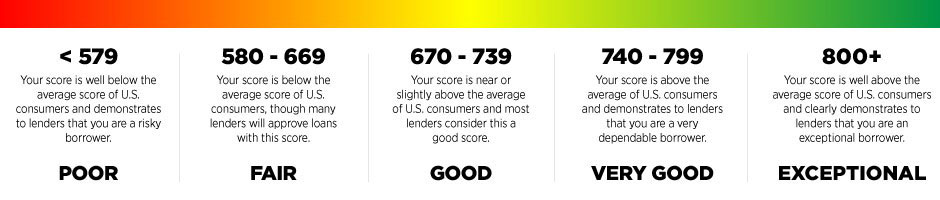

In [50]:
df['fico_rating'] = df.apply(lambda row: 'Poor' if row['fico_mean'] < 580
                                    else 'Fair' if row['fico_mean'] < 670
                                    else 'Good' if row['fico_mean'] < 740
                                    else 'Very Good' if row['fico_mean'] < 800
                                    else 'Exceptional', axis=1)

###W jaki sposób wynik FICO wiąże się z prawdopodobieństwem spłacenia pożyczki przez pożyczkobiorcę?

`fico_rating` vs `loan_status`

In [51]:
fig = go.Figure()

# Dodanie pudełka dla "Charged Off"
fig.add_trace(go.Box(x=df['loan_status'][df['loan_status'] == 'Charged Off'],
                     y=df['fico_mean'],
                     name='Charged Off',
                     line_color='red'
                     ))

# Dodanie pudełka dla "Fully Paid"
fig.add_trace(go.Box(x=df['loan_status'][df['loan_status'] == 'Fully Paid'],
                     y=df['fico_mean'],
                     name='Fully Paid',
                     line_color='green'
                     ))

fig.update_layout(title="Zależność spłacalności pożyczki od punktów FICO",
                  xaxis_title="loan_status",
                  yaxis_title="fico_mean",
                  template='plotly_dark',
                  )

fig.show()

In [52]:
px.violin(df, y='fico_mean', color='loan_status', violinmode='overlay', title="Zależność spłacalności pożyczki od punktów FICO",
                template="plotly_dark", color_discrete_map={'Fully Paid': 'green', 'Charged Off': 'red'})

In [53]:
chi2_test('fico_rating', 'loan_status',1)

loan_status  Charged Off  Fully Paid
fico_rating                         
Exceptional     0.005406    0.016277
Fair            0.151534    0.081138
Good            0.706472    0.645681
Very Good       0.136588    0.256904

chi2: 0.06627081699437917
p value: 0.995551799615291
Independent (fail to reject H0)


WNIOSKI:

1. Na podstawie przedstawionych wykresów wnioskuję, iż więcej pożyczek jest spłaconych
przez pożyczkobiorców z wyższym  wynikiem FICO.

2. Jednak test chi2 nie wykazał istotnych różnic między grupami "Fully Paid" a "Charged Off". Wartość p sugeruje, że nie ma statystycznie istotnej zależności między tymi dwiema grupami.

Na podstawie tego można stwierdzić, że nie należy się kierować tylko oceną FICO w udzieleniu pożyczki.

### W jaki sposób wiek kredytowy wiąże się z prawdopodobieństwem niewykonania zobowiązania i czy ryzyko to jest niezależne lub związane z wynikiem FICO

`earliest_cr_line` vs `loan_status`

In [54]:
plot = go.Figure()

plot.add_trace(
    go.Violin(
        x=df['loan_status'][df['loan_status'] == 'Charged Off'],
        y=df["earliest_cr_line_year"],
        meanline_visible=True,
        line_color='red',
        name='Charged off'
        ))

plot.add_trace(
    go.Violin(
        x=df['loan_status'][df['loan_status'] == 'Fully Paid'],
        y=df["earliest_cr_line_year"],
        meanline_visible=True,
        line_color='green',
        name='Fully Paid'
        ))

plot.update_layout(violinmode='group',
                  title="Loan Amount",
                  xaxis_title="Porównanie rozkładu lat wzięcia kredytu hipotecznego w zależności od spłaty pożyczki",
                  yaxis_title="earliest_cr_line_year",
                  template='plotly_dark',
                  violingroupgap=0.1
                  )

plot.show()

WNIOSKI:

Na podstawie wykresu violinowego widzimy, że średni wiek kredytowy nie ma większego wpływu na spłatę pożyczki.

###W jaki sposób status kredytu hipotecznego na dom wiąże się z prawdopodobieństwem niewypłacalności?

`home_ownership` vs `loan_status`

In [55]:
fig = go.Figure()

fig.add_trace(
    go.Bar(
        x=df.query("loan_status == 'Fully Paid'").home_ownership.value_counts().index.tolist(),
        y=df.query("loan_status == 'Fully Paid'").home_ownership.value_counts().values.tolist(),
        marker_color='green',
        textposition='auto',
        name='Fully Paid',
    )
)

fig.add_trace(
    go.Bar(
        x=df.query("loan_status == 'Fully Paid'").home_ownership.value_counts().index.tolist(),
        y=df.query("loan_status == 'Charged Off'").home_ownership.value_counts().values.tolist(),
        marker_color='red',
        textposition='auto',
        name='Charged Off',
    )
)

fig.update_layout(
    title="Analiza liczności 'home_ownership' a status spłaty pożyczki",
    xaxis_title="home_ownership",
    yaxis_title="counts",
    template="plotly_dark",
)

fig.show()

In [56]:
chi2_test('home_ownership', 'loan_status', 1)

loan_status     Charged Off  Fully Paid
home_ownership                         
MORTGAGE           0.419304    0.450299
NONE               0.000159    0.000193
OTHER              0.004611    0.002952
OWN                0.076483    0.076420
RENT               0.499443    0.470135

chi2: 0.0023580596105293333
p value: 0.9999993054904452
Independent (fail to reject H0)


1. Wykres słupkowy statusy kredytu hipotecznego nie wykazał znaczących różnic między grupami "Fully Paid" a "Charged Off".

2. Test chi2 również nie wykazał istotnych różnic między grupami "Fully Paid" a "Charged Off". Wartość p sugeruje, że nie ma statystycznie istotnej zależności między dwiema grupami.

Na podstawie tego nie można jednoznacznie stwierdzić, że status kredytu hipotecznego ma istotny wpływ na spłacalność pożyczki.

###W jaki sposób roczny dochód wiąże się z prawdopodobieństwem niewykonania zobowiązania?

`annual_inc` vs `loan_status`

In [57]:
fig = go.Figure()

fig.add_trace(
    go.Box(
        x=df['loan_status'][df['loan_status'] == 'Charged Off'],
        y=df.query("loan_status == 'Charged Off'").annual_inc.values.tolist(),
        name='Charged Off',
        line_color='red',
        ))

fig.add_trace(
    go.Box(
        x=df['loan_status'][df['loan_status'] == 'Fully Paid'],
        y=df.query("loan_status == 'Fully Paid'").annual_inc.values.tolist(),
        name='Fully Paid',
        line_color='green'
        ))

fig.update_layout(
    title="Zależność spłacalności pożyczki od rocznych dochodów",
    xaxis_title="loan_status",
    yaxis_title="annual_inc",
    template='plotly_dark',
    yaxis_type='log'
    )

fig.show()

WNIOSKI:

Analiza wykresu skrzyniowego dla rocznych dochodów nie wykazała istotnych różnic między grupami "Fully Paid" a "Charged Off". Mediana na obu wykresach pudełkowych nie różni się znacząco, co oznacza, że średnie roczne dochody między tymi grupami są podobne. Dodatkowo, wartości Upper i Lower fence na obu wykresach pudełkowych są zbliżone, co sugeruje, że obie grupy mają podobne zakresy rozkładu danych.

Na podstawie tych obserwacji można stwierdzić, że roczne dochody nie wydają się być istotnym czynnikiem różnicującym spłacalność pożyczki między grupami "Fully Paid" a "Charged Off".

###W jaki sposób historia zatrudnienia wiąże się z prawdopodobieństwem niewykonania zobowiązania?

`emp_length` vs `loan_status`

In [58]:
fig = go.Figure()

fig.add_trace(
    go.Box(
        x=df['loan_status'][df['loan_status'] == 'Charged Off'],
        y=df.query("loan_status == 'Charged Off'").emp_length.values.tolist(),
        name='Charged Off',
        line_color='red',
        ))

fig.add_trace(
    go.Box(
        x=df['loan_status'][df['loan_status'] == 'Fully Paid'],
        y=df.query("loan_status == 'Fully Paid'").emp_length.values.tolist(),
        name='Fully Paid',
        line_color='green'
        ))

fig.update_layout(
    title="Zależność spłacalności pożyczki od historii zatrudnienia",
    xaxis_title="loan_status",
    yaxis_title="emp_length",
    template='plotly_dark',
    )

fig.show()

In [59]:
data_cross = pd.crosstab(df['loan_status'], df['emp_length'], margins=False, normalize='index')
data_cross = data_cross.reindex(['< 1 year', '1 year', '2 years', '3 years', '4 years', '5 years',
                '6 years', '7 years', '8 years', '9 years', '10+ years'], axis=1)
data_cross

emp_length   < 1 year    1 year   2 years   3 years   4 years   5 years  \
loan_status                                                               
Charged Off  0.117189  0.085546  0.102242  0.097949  0.082048  0.078868   
Fully Paid   0.119320  0.084338  0.113113  0.103402  0.086435  0.081717   

emp_length    6 years   7 years   8 years   9 years  10+ years  
loan_status                                                     
Charged Off  0.055017  0.046271  0.036731  0.027985   0.270154  
Fully Paid   0.055977  0.043700  0.037548  0.032141   0.242310

In [60]:
fig = go.Figure()

fig.add_trace(
    go.Bar(
        x=data_cross.columns,
        y=data_cross.loc['Fully Paid', :] * 100,
        marker_color='green',
        textposition='auto',
        name='Fully Paid',
        xaxis='x'
    )
)

fig.add_trace(
    go.Bar(
        x=data_cross.columns,
        y=data_cross.loc['Charged Off', :] * 100,
        marker_color='red',
        textposition='auto',
        name='Charged Off',
        xaxis='x'
    )
)

fig.update_layout(
    title="% 'emp_length' for 'loan_status'",
    xaxis_title='emp_length',
    yaxis_title="% emp_length",
    template="plotly_dark",
    legend_title="loan_status"
)

fig.show()

In [61]:
chi2_test('emp_length', 'loan_status', 1)

loan_status  Charged Off  Fully Paid
emp_length                          
1 year          0.085546    0.084338
10+ years       0.270154    0.242310
2 years         0.102242    0.113113
3 years         0.097949    0.103402
4 years         0.082048    0.086435
5 years         0.078868    0.081717
6 years         0.055017    0.055977
7 years         0.046271    0.043700
8 years         0.036731    0.037548
9 years         0.027985    0.032141
< 1 year        0.117189    0.119320

chi2: 0.0027798397091134994
p value: 1.0
Independent (fail to reject H0)


WNIOSKI:

1. Wykres skrzyniowy dla historii zatrudnienia nie wykazał istotnych różnic między grupami "Fully Paid" a "Charged Off".

2. Wykres słupkowy procentowego rozkładu historii zatrudnienia nie wykazał znaczących różnic między grupami "Fully Paid" a "Charged Off".

3. Test chi2 również nie wykazał istotnych różnic między grupami "Fully Paid" a "Charged Off". Wartość p sugeruje, że nie ma statystycznie istotnej zależności między dwiema grupami.

Na podstawie tego nie można jednoznacznie stwierdzić, że historia zatrudnienia ma istotny wpływ na spłacalność pożyczki.

###Jak wielkość żądanej pożyczki jest powiązana z prawdopodobieństwem niewykonania zobowiązania?

`loan_amnt` vs `loan_status`

In [62]:
fig = go.Figure()

# Dodanie pudełka dla "Charged Off"
fig.add_trace(
    go.Box(
        x=df['loan_status'][df['loan_status'] == 'Charged Off'],
        y=df.query("loan_status == 'Charged Off'").loan_amnt.values.tolist(),
        name='Charged Off',
        line_color='red',
        ))

# Dodanie pudełka dla "Fully Paid"
fig.add_trace(
    go.Box(
        x=df['loan_status'][df['loan_status'] == 'Fully Paid'],
        y=df.query("loan_status == 'Fully Paid'").loan_amnt.values.tolist(),
        name='Fully Paid',
        line_color='green'
        ))

fig.update_layout(
    title="Zależność wielkości żądanej pożyczki od rocznych dochodów",
    xaxis_title="loan_status",
    yaxis_title="loan_amnt",
    template='plotly_dark',
    )

fig.show()

In [63]:
px.violin(df, y='loan_amnt', color='loan_status', violinmode='overlay', title="Zależność spłacalności pożyczki od wielkości żądanej pożyczki",
                template="plotly_dark", color_discrete_map={'Fully Paid': 'green', 'Charged Off': 'red'})

In [64]:
chi2_test('loan_amnt', 'loan_status', 1)

loan_status  Charged Off  Fully Paid
loan_amnt                           
500.0           0.000159    0.000276
550.0           0.000000    0.000028
600.0           0.000159    0.000138
700.0           0.000159    0.000055
725.0           0.000000    0.000028
...                  ...         ...
34475.0         0.000159    0.000110
34525.0         0.000000    0.000028
34675.0         0.000000    0.000028
34800.0         0.000000    0.000055
35000.0         0.022897    0.014925

[898 rows x 2 columns]

chi2: 0.08915231181505592
p value: 1.0
Independent (fail to reject H0)


WNIOSKI:

1. Wykres skrzyniowy dla wielkości żądanej pożyczki nie wykazał istotnych różnic między grupami "Fully Paid" a "Charged Off".

2. Wykres skrzypcowy pokazał, że niskie kwoty były spłacane częściej, a najwyższe rzadziej.

2. Test chi2 również nie wykazał istotnych różnic między grupami "Fully Paid" a "Charged Off". Wartość p sugeruje, że nie ma statystycznie istotnej zależności między dwiema grupami.

Na podstawie tego nie można jednoznacznie stwierdzić, że wielkość żądanej pożyczki ma istotny wpływ na spłacalność pożyczki.

##3. Feature Engineering

###debt_to_income_per_term

Cecha ta pomaga w zrozumieniu stosunku miesięcznego zadłużenia kredytobiorcy do miesięcznego dochodu rozłożonego na cały okres kredytowania, dając wgląd w przystępność kredytobiorcy.

In [65]:
df['term'] = df['term'].str.replace(' months', '').astype(int)

In [66]:
df["debt_to_income_per_term"] = df["dti"] / df["term"]

In [67]:
df["debt_to_income_per_term"].head()

0    0.768056
1    0.016667
2    0.242222
3    0.555556
4    0.299000
Name: debt_to_income_per_term, dtype: float64

###loan_to_income

Daje wgląd w to, w jakim stopniu kwota pożyczki odpowiada rocznemu dochodowi pożyczkobiorcy, co pozwala nam zrozumieć, czy pożyczka może być przystępna dla pożyczkobiorcy.

In [68]:
df["loan_to_income"] = df["loan_amnt"] / df["annual_inc"]

In [69]:
df["loan_to_income"].head()

0    0.208333
1    0.083333
2    0.195886
3    0.203252
4    0.037500
Name: loan_to_income, dtype: float64

###credit_history_length

Pomaga nam zrozumieć, jak długa jest historia kredytowa pożyczkobiorcy, co może być dobrym wskaźnikiem zdolności kredytowej.

In [70]:
df['credit_history_length'] = (datetime.today().date() - df['earliest_cr_line'].dt.date).dt.days

In [71]:
df['credit_history_length'].head()

0    14157
1     8954
2     8009
3    10109
4    10140
Name: credit_history_length, dtype: int64

###total_openness

Cecha ta może zapewnić wgląd w odsetek otwartych linii kredytowych w porównaniu do całkowitych linii kredytowych kredytobiorcy. Wysoka wartość może oznaczać, że pożyczkobiorca wykorzystuje znaczną część dostępnego kredytu.

In [72]:
df["total_openness"] = df["open_acc"] / df["total_acc"]

In [73]:
df["total_openness"].head()

0    0.333333
1    0.750000
2    0.200000
3    0.270270
4    0.394737
Name: total_openness, dtype: float64

###installment_to_income_ratio

Stanowi on stosunek miesięcznej raty pożyczkobiorcy do jego rocznego dochodu, dając wgląd w zdolność pożyczkobiorcy do spłaty.

In [74]:
df["installment_to_income_ratio"] = df["installment"] / df["annual_inc"]

In [75]:
df["installment_to_income_ratio"].head()

0    0.006786
1    0.001994
2    0.006883
3    0.006897
4    0.000847
Name: installment_to_income_ratio, dtype: float64

###utilization_rate

Pomaga zrozumieć, jak intensywnie wykorzystuje dostępne linie kredytowe w stosunku do ogólnej liczby posiadanych kont kredytowych. Im wyższy wskaźnik, tym większa jest zależność od kredytów lub napięcie finansowe.

In [76]:
df["utilization_rate"] = df["revol_util"] / df["total_acc"]

In [77]:
df["utilization_rate"].head()

0    9.300000
1    2.350000
2    9.850000
3    0.567568
4    1.418421
Name: utilization_rate, dtype: float64

###delinquency_rate


Może byc użyteczny do oceny ryzyka kredytobiorcy pod względem opóźnień w spłacie zobowiązań finansowych. Im wyższy wskaźnik, tym większa jest szansa na opóźnienia w spłatach.

In [78]:
df["delinquency_rate"] = df["delinq_2yrs"] / df["total_acc"]

In [79]:
df["delinquency_rate"].head()

0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: delinquency_rate, dtype: float64

In [80]:
df["delinquency_rate"].value_counts()

0.000000    37801
0.050000      160
0.066667      155
0.052632      154
0.076923      151
            ...  
0.032787        1
0.026667        1
0.065217        1
0.015152        1
0.619048        1
Name: delinquency_rate, Length: 176, dtype: int64

In [81]:
df.drop("delinquency_rate", inplace=True, axis=1, errors='ignore')

###months_since_last_credit_pull

Służy do określenia ilości miesięcy od ostatniej aktualizacji informacji o kredytobiorcy na temat jego zdolności kredytowej. Ta zmienna może być użyteczna w analizie kredytowej, aby ocenić, jak często kredytobiorca aktualizuje swoje informacje kredytowe. Dłuższy okres od ostatniej aktualizacji może sugerować, że informacje kredytowe mogą być przestarzałe.

In [82]:
ref_date = df['last_credit_pull_d'].min()

df['months_since_last_credit_pull'] = (
    df['last_credit_pull_d'].dt.year - ref_date.year) * 12 \
    + df['last_credit_pull_d'].dt.month - ref_date.month

df.drop(columns=["last_credit_pull_d"], axis=1, inplace=True)

In [83]:
df['months_since_last_credit_pull'].head()

0    135
1    113
2    121
3    107
4    131
Name: months_since_last_credit_pull, dtype: int64

###fraction_of_neg_public_records

Mierzy stosunek liczby negatywnych wpisów w historii publicznych rekordów kredytowych (zazwyczaj związanych z incydentami takimi jak zaległe płatności lub windykacje) do ogólnej liczby kont kredytowych

In [84]:
df['fraction_of_neg_public_records'] = df['pub_rec'] / df['total_acc']

In [85]:
df['fraction_of_neg_public_records'].head()

0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: fraction_of_neg_public_records, dtype: float64

In [86]:
df['fraction_of_neg_public_records'].value_counts()

0.000000    40160
0.058824      112
0.050000      107
0.055556      102
0.062500      102
            ...  
0.115385        1
0.051282        1
0.064516        1
0.187500        1
0.035088        1
Name: fraction_of_neg_public_records, Length: 85, dtype: int64

In [87]:
df.drop('fraction_of_neg_public_records', inplace=True, axis=1, errors='ignore')

###monthly_income

Pozwala pożyczkodawcom i instytucjom finansowym ocenić zdolność kredytobiorcy do regulowania miesięcznych zobowiązań finansowych, takich jak raty kredytowe lub czynsz.

In [88]:
df['monthly_income'] = df['annual_inc'] / 12
df.drop(columns=['annual_inc'], inplace=True)

In [89]:
df['monthly_income'].head()

0    2000.000000
1    2500.000000
2    1021.000000
3    4100.000000
4    6666.666667
Name: monthly_income, dtype: float64

###available_credit

Jest to estymacja dostępnej zdolności kredytowej pożyczkobiorcy w kontekście jego otwartych kont. Im wyższa wartość "available_credit", tym więcej dostępnej kredytowej przestrzeni pozostaje pożyczkobiorcy. Niższa może sugerować, że pożyczkobiorca jest bardziej obciążony zadłużeniem.

In [90]:
df['availabile_credit'] = df['open_acc'] * df['revol_util']

In [91]:
df['availabile_credit'].head()

0    251.1
1     28.2
2    197.0
3    210.0
4    808.5
Name: availabile_credit, dtype: float64

###payment_to_revolving_ratio

Wyraża ona, jak duży jest udział comiesięcznej raty w wykorzystaniu dostępnego kredytu. Im wyższa wartość tej zmiennej, tym większy wpływ spłaty kredytu ma na ogólny poziom wykorzystania kredytu przez pożyczkobiorcę. Wyższy stosunek może sugerować, że pożyczkobiorca ma zdolność do spłaty kredytu wobec swojego ogólnego zadłużenia, podczas gdy niższy stosunek może wskazywać na większe ryzyko niewypłacalności.

In [92]:
df['revol_util'].replace(0, 0.001, inplace=True)
df['payment_to_revolving_ratio'] = df['installment'] / df['revol_util']

In [93]:
df['payment_to_revolving_ratio'].head()

0     1.945878
1     6.364894
2     0.856142
3    16.157619
4     1.257699
Name: payment_to_revolving_ratio, dtype: float64

###loan_to_installment_ratio

Oznacza ile ratalnych płatności jest potrzebnych do spłacenia całej pożyczki. Pozwala lepiej zrozumieć zależności między różnymi aspektami finansowego profilu pożyczkobiorcy a jego zdolnością do spłaty pożyczki.

In [94]:
df['loan_to_installment_ratio'] = df['loan_amnt'] / df['installment']

In [95]:
df['loan_to_installment_ratio'].head()

0    30.699331
1    41.785058
2    28.459623
3    29.471575
4    44.254315
Name: loan_to_installment_ratio, dtype: float64

###salary_without_installment

Oznacza ile pieniędzy pozostaje po odjęciu miesięcznej raty od miesięcznych dochodów. Pokazuje, ile pozostaje pożyczkobiorcy środków do dyspozycji po opłaceniu raty.

In [96]:
df['salary_without_installment'] = (df['monthly_income'] - df['installment']).astype(int)

In [97]:
df['salary_without_installment'].head()

0    1837
1    2440
2     936
3    3760
4    6598
Name: salary_without_installment, dtype: int64

###income_per_credit

 Oznacza ile średnio dochodu przypada na jedną otwartą linię kredytową. Wyższa wartość może sugerować dobrą zdolność kredytową, ponieważ pożyczkobiorca może łatwiej zarządzać swoimi zobowiązaniami kredytowymi.

In [98]:
df['income_per_credit'] = df['monthly_income'] / df['open_acc']

In [99]:
df['income_per_credit'].head()

0    666.666667
1    833.333333
2    510.500000
3    410.000000
4    444.444444
Name: income_per_credit, dtype: float64

###Korelacje

In [100]:
df.drop("earliest_cr_line", inplace=True, axis=1, errors='ignore')

In [101]:
encoder = LabelEncoder()

df_numeric = df.copy()
for column in df.select_dtypes(object):
  df_numeric[column] = encoder.fit_transform(df_numeric[column])

selected_columns = df_numeric.select_dtypes(include=['datetime64']).columns.tolist()
df[selected_columns].head()

if selected_columns:
  df_numeric.drop(selected_columns, inplace=True, axis=1, errors='ignore')
df_numeric = df_numeric.astype(float)



In [102]:
df_numeric_corr = df_numeric.corr()

fig = go.Figure(
    data=go.Heatmap(
      z=df_numeric_corr,
      x=df_numeric.columns,
      y=df_numeric.columns,
      colorscale='Viridis'
    ))

fig.update_layout(
    title="Heatmap df_numeric",
    xaxis_title="Columns",
    yaxis_title="Columns",
    template='plotly_dark'
)

fig.show()

In [103]:
high_corr_pairs = find_correlation_pairs(df_numeric_corr, 0.7, 1)
display(high_corr_pairs)

column1                        column2  correlation
0                    loan_amnt                    installment     0.930869
1                    loan_amnt                    total_pymnt     0.882832
2                    loan_amnt                total_pymnt_inv     0.844173
3                    loan_amnt                  total_rec_int     0.729107
4                     int_rate                          grade     0.939154
5                     int_rate                      sub_grade     0.950589
6                     int_rate                      fico_mean    -0.702575
7                  installment                    total_pymnt     0.848587
8                  installment                total_pymnt_inv     0.799627
9                        grade                      sub_grade     0.980993
10                   sub_grade                      fico_mean    -0.706150
11                         dti        debt_to_income_per_term     0.908543
12                     pub_rec           pub_rec_bankruptcies     0.824237
13                 total_pymnt                total_pymnt_inv     0.965070
14                 total_pymnt                  total_rec_int     0.836641
15             total_pymnt_inv                  total_rec_int     0.819354
16     last_credit_pull_d_year  months_since_last_credit_pull     0.994376
17       earliest_cr_line_year          credit_history_length    -0.999072
18              loan_to_income    installment_to_income_ratio     0.930731
19              monthly_income     salary_without_installment     0.999279
20              monthly_income              income_per_credit     0.703341
21  salary_without_installment              income_per_credit     0.707485

In [104]:
loan_status_corr_pairs = df_numeric_corr['loan_status'].drop('loan_status')

In [105]:
fig = go.Figure()

fig.add_trace(
    go.Bar(
        x=loan_status_corr_pairs.index.tolist(),
        y=loan_status_corr_pairs.tolist(),
        marker_color='green',
        textposition='auto',
        name='Correlations',
        xaxis='x'
    )
)


fig.update_layout(
    title="Correlations with 'loan_status'",
    yaxis_title='Correlations',
    template="plotly_dark"
)

fig.show()

##4. Modelowanie

###Outliers

In [106]:
df_outliers = df.select_dtypes(include='float64').copy()
outliers_info = find_outliers(df_outliers)
display(outliers_info)

Q1            Q3           IQR  \
loan_amnt                    5200.000000  15000.000000   9800.000000   
int_rate                        9.630000     14.720000      5.090000   
installment                   165.535000    428.155000    262.620000   
dti                             8.200000     18.680000     10.480000   
revol_bal                    3634.000000  17250.500000  13616.500000   
revol_util                     25.575000     72.600000     47.025000   
total_acc                      13.000000     29.000000     16.000000   
total_pymnt                  5464.990263  16427.733390  10962.743127   
total_pymnt_inv              4792.975000  15543.807500  10750.832500   
total_rec_int                 657.097500   2803.020000   2145.922500   
last_pymnt_amnt               211.035000   3170.165000   2959.130000   
fico_mean                     687.000000    742.000000     55.000000   
debt_to_income_per_term         0.193833      0.458611      0.264778   
loan_to_income                  0.097674      0.250000      0.152326   
total_openness                  0.333333      0.588235      0.254902   
installment_to_income_ratio     0.002914      0.007332      0.004417   
utilization_rate                1.082759      4.000000      2.917241   
monthly_income               3333.333333   6875.000000   3541.666667   
availabile_credit             196.800000    631.400000    434.600000   
payment_to_revolving_ratio      3.508648     12.429814      8.921166   
loan_to_installment_ratio      29.791561     38.209259      8.417699   
income_per_credit             384.615385    861.111111    476.495726   

                              lower_bound   upper_bound  outliers_count  
loan_amnt                    -9500.000000  29700.000000            1218  
int_rate                         1.995000     22.355000              94  
installment                   -228.395000    822.085000            1393  
dti                             -7.520000     34.400000               0  
revol_bal                   -16790.750000  37675.250000            2906  
revol_util                     -44.962500    143.137500               0  
total_acc                      -11.000000     53.000000             604  
total_pymnt                 -10979.124428  32871.848081            1436  
total_pymnt_inv             -11333.273750  31670.056250            1550  
total_rec_int                -2561.786250   6021.903750            3357  
last_pymnt_amnt              -4227.660000   7608.860000            4667  
fico_mean                      604.500000    824.500000               3  
debt_to_income_per_term         -0.203333      0.855778               0  
loan_to_income                  -0.130814      0.478488             970  
total_openness                  -0.049020      0.970588             981  
installment_to_income_ratio     -0.003711      0.013957             812  
utilization_rate                -3.293103      8.375862            2634  
monthly_income               -1979.166667  12187.500000            2032  
availabile_credit             -455.100000   1283.300000             892  
payment_to_revolving_ratio      -9.873101     25.811563            5139  
loan_to_installment_ratio       17.165013     50.835807            1321  
income_per_credit             -330.128205   1575.854701            2461

In [107]:
for col in df_outliers.columns:
    if col in outliers_info.index:
        lower_bound = outliers_info.loc[col, 'lower_bound']
        upper_bound = outliers_info.loc[col, 'upper_bound']
        df_outliers[col] = df_outliers[col].clip(lower=lower_bound, upper=upper_bound)

In [108]:
df_numeric[df_outliers.columns] = df_outliers
df[df_outliers.columns] = df_outliers

###Standard scaler - dummies, numeric

In [110]:
df.shape

(42536, 46)

In [ ]:
df_numeric_std = sc.fit_transform(df_numeric)
df_numeric_std = pd.DataFrame(df_numeric_std, columns=df_numeric.columns)
print(df_numeric_std.shape)
df_numeric_std.head()

In [109]:
df_dummies = pd.get_dummies(df.drop('loan_status',axis=1))
df_dummies.columns = [col.replace('[', '_').replace(']', '_').replace('<', '_') for col in df_dummies.columns]

In [115]:
sc = StandardScaler()

df_dummies_std = sc.fit_transform(df_dummies.select_dtypes(include='number'))
df_dummies_std = pd.DataFrame(df_dummies_std, columns=df_dummies.select_dtypes(include='number').columns)
print(df_dummies_std.shape)
df_dummies_std.head()

###Podział zbioru na testowy i treningowy

In [234]:
Y = df_numeric['loan_status']
X = df_numeric_std

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.7, random_state=42)

print(X_train.shape)

(12760, 46)


###SMOTE

In [235]:
from imblearn.over_sampling import SMOTE

# Wykorzystanie SMOTE do zrównoważenia zbioru treningowego
smote = SMOTE(sampling_strategy=1.0, random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

# Sprawdzenie, czy liczność klas jest teraz zrównoważona
unique, counts = np.unique(y_train, return_counts=True)
print(dict(zip(unique, counts)))

{0.0: 10841, 1.0: 10841}


##Klasteryzacja

###K-Means Clustering

In [236]:
from sklearn.metrics import silhouette_score

range_n_clusters = [2, 4, 6, 8, 10, 12]
for num_clusters in range_n_clusters:
    klaster = KMeans(n_clusters=num_clusters, max_iter=1000, n_init=10)
    cluster_labels = klaster.fit_predict(X)

    # silhouette score
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters={0}, the silhouette score is {1}".format(num_clusters,
                                                                   silhouette_avg))

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



For n_clusters=2, the silhouette score is 0.13363745632392943


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



For n_clusters=4, the silhouette score is 0.08638286091127327


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



For n_clusters=6, the silhouette score is 0.08429783091008641


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



For n_clusters=8, the silhouette score is 0.07542761394409214


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



For n_clusters=10, the silhouette score is 0.07607858794203647


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



For n_clusters=12, the silhouette score is 0.05961232618878267


In [217]:
from sklearn.cluster import KMeans

kmeans_c = KMeans(n_clusters=2)
kmeans_c.fit(X)

labels = kmeans_c.labels_
centroids = kmeans_c.cluster_centers_

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



In [218]:
cm = confusion_matrix(Y, labels)
plot_confusion_matrix(cm,'K-Means Clustering')

###DBSCAN

In [121]:
from sklearn.cluster import DBSCAN
# Inicjalizacja modelu DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=20)

# Dopasowanie modelu do danych
dbscan.fit(X)

# Wyodrębnienie przypisanych klastrów dla każdej próbki (-1 oznacza punkty odstające)
labels = dbscan.labels_

print("Przypisane klastry dla każdej próbki:")
print(labels)

Przypisane klastry dla każdej próbki:
[-1 -1 -1 ... -1 -1 -1]


In [122]:
pd.Series(labels).value_counts()

-1    42536
dtype: int64

###Hierarchical Clustering

In [123]:
# Wybranie losowo 1000 próbek
random_indices = np.random.choice(df_numeric.shape[0], 1000, replace=False)
HC_X = df_numeric.iloc[random_indices]

In [124]:
from scipy.cluster.hierarchy import dendrogram, linkage

linkage_matrix = linkage(HC_X, method='ward')

##Klasyfikacja

In [ ]:
Y = df_numeric['loan_status']
X = df_dummies_std.astype(float)

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.7, random_state=42)

# Wykorzystanie SMOTE do zrównoważenia zbioru treningowego
smote = SMOTE(sampling_strategy=1.0, random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

print(X_train.shape)

###Logistic Regression

####Random Search

In [125]:
log_reg_c = LogisticRegression()

# Definicja przestrzeni parametrów do strojenia
param_grid = {
    'penalty': ['l1', 'l2'],  # Rodzaj regularyzacji
    'C': [0.001, 0.01, 0.1, 1, 10, 100],  # Odwrotność parametru regularyzacji
    'solver': ['liblinear', 'saga']  # Algorytm optymalizacji
}

random_search = RandomizedSearchCV(log_reg_c, param_distributions=param_grid,
                                   n_iter=10, cv=5, random_state=42)

random_search.fit(X_train, y_train)

# Najlepsze znalezione parametry
best_params = random_search.best_params_
print("Najlepsze parametry:", best_params)

# Ostateczna ocena modelu na zbiorze testowym
accuracy = random_search.score(X_test, y_test)
print("Dokładność na zbiorze testowym:", accuracy)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/usr/local/lib/python3.10/dist-packages/

Najlepsze parametry: {'solver': 'liblinear', 'penalty': 'l1', 'C': 10}
Dokładność na zbiorze testowym: 0.9755507791509941


In [226]:
log_reg_c = LogisticRegression(solver = 'liblinear', penalty = 'l1', C = 10)
log_reg_c.fit(X_train, y_train)

LogisticRegression(C=10, penalty='l1', solver='liblinear')

####Predykcja na podstawie modelu

In [227]:
log_reg_y_pred = log_reg_c.predict(X_test)
log_reg_y_pred[:5]

array([1., 1., 1., 1., 1.])

In [128]:
log_reg_y_prob = log_reg_c.predict_proba(X_test)
print(log_reg_y_prob[:5])

[[1.10513221e-06 9.99998895e-01]
 [8.61533067e-14 1.00000000e+00]
 [5.03988372e-06 9.99994960e-01]
 [1.74294659e-02 9.82570534e-01]
 [9.75520969e-05 9.99902448e-01]]


####Confusion Matrix

In [228]:
cm = confusion_matrix(y_test, log_reg_y_pred)
plot_confusion_matrix(cm,'Logistic Regression')

####Clasification report

In [222]:
print(classification_report(y_test, log_reg_y_pred))

              precision    recall  f1-score   support

         0.0       0.96      0.89      0.92      4370
         1.0       0.98      0.99      0.99     25406

    accuracy                           0.98     29776
   macro avg       0.97      0.94      0.95     29776
weighted avg       0.98      0.98      0.98     29776



####ROC Curve

In [229]:
plot_roc_curve(y_test, log_reg_y_pred, 'Logistic Regression')

####Validation

In [230]:
log_reg_mv = model_validation(y_test, log_reg_y_pred, 'log_reg')
display(log_reg_mv)

accuracy  precision    recall        f1     AUROC       fpr      fnr
log_reg  0.974879    0.97475  0.974879  0.974807  0.947006  0.092449  0.01354

In [231]:
# Wartości współczynników (wag) cech
features = pd.DataFrame(data={'feature': X.columns, 'Coefficient': log_reg_c.coef_.tolist()[0]})
px.bar(features, x='feature', y='Coefficient', width=700, height=400, template='plotly_dark')

###K-najbliższych sąsiadów

####Random Search

In [134]:
from sklearn.neighbors import KNeighborsClassifier

knn_c = KNeighborsClassifier()

# Definicja przestrzeni parametrów do strojenia
param_grid = {
    'n_neighbors': range(1, 21),    # liczba sąsiadów
    'weights': ['uniform', 'distance'],  # wagi
    'p': [1, 2]  # parametr p (1 dla manhattan, 2 dla euclidean)
}

random_search = RandomizedSearchCV(knn_c, param_distributions=param_grid,
                                   n_iter=10, cv=5, random_state=42)

random_search.fit(X_train, y_train)

# Najlepsze znalezione parametry
best_params = random_search.best_params_
print("Najlepsze parametry:", best_params)

# Ostateczna ocena modelu na zbiorze testowym
accuracy = random_search.score(X_test, y_test)
print("Dokładność na zbiorze testowym:", accuracy)

Najlepsze parametry: {'weights': 'uniform', 'p': 1, 'n_neighbors': 8}
Dokładność na zbiorze testowym: 0.8620365394948952


In [135]:
knn_c = KNeighborsClassifier(n_neighbors=8, weights='uniform', p=1)
knn_c.fit(X_train, y_train)
knn_y_pred = knn_c.predict(X_test)

####Confusion Matrix

In [136]:
cm = confusion_matrix(y_test, knn_y_pred)
plot_confusion_matrix(cm,'K-NN')

####Clasification report

In [137]:
print(classification_report(y_test, knn_y_pred))

              precision    recall  f1-score   support

         0.0       0.57      0.23      0.33      4370
         1.0       0.88      0.97      0.92     25406

    accuracy                           0.86     29776
   macro avg       0.73      0.60      0.63     29776
weighted avg       0.84      0.86      0.84     29776



####ROC Curve

In [138]:
plot_roc_curve(y_test, knn_y_pred, 'K-NN')

####Validation

In [139]:
K_NN_mv = model_validation(y_test, knn_y_pred, 'K_NN')
display(K_NN_mv)

accuracy  precision    recall        f1     AUROC       fpr       fnr
K_NN  0.862037   0.835179  0.862037  0.835858  0.600366  0.770023  0.029245

###Lasy losowe

####Random Search

In [140]:
from sklearn.ensemble import RandomForestClassifier

rf_c = RandomForestClassifier()

param_grid = {
    'n_estimators': [50, 100, 150, 200],  # Liczba drzew w lesie
    'max_depth': [None, 10, 20, 30],  # Maksymalna głębokość drzewa
    'min_samples_split': [2, 5, 10],  # Minimalna liczba próbek do podziału węzła
    'min_samples_leaf': [1, 2, 4]  # Minimalna liczba próbek w liściu
}

random_search = RandomizedSearchCV(rf_c, param_distributions=param_grid,
                                   n_iter=10, cv=5, random_state=42)

random_search.fit(X_train, y_train)

# Najlepsze znalezione parametry
best_params = random_search.best_params_
print("Najlepsze parametry:", best_params)

# Ostateczna ocena modelu na zbiorze testowym
accuracy = random_search.score(X_test, y_test)
print("Dokładność na zbiorze testowym:", accuracy)

Najlepsze parametry: {'n_estimators': 150, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_depth': 20}
Dokładność na zbiorze testowym: 0.948649919398173


In [141]:
rf_c = RandomForestClassifier(n_estimators=100, min_samples_split = 10,
                              min_samples_leaf = 1, max_depth = 30,
                              random_state=42)

start_time = time.time()
rf_c.fit(X_train, y_train)
end_time = time.time()

In [142]:
execution_time = end_time - start_time
print(f"Czas wykonania: {execution_time} sekundy")

Czas wykonania: 2.4794251918792725 sekundy


In [143]:
rf_y_pred = rf_c.predict(X_test)

####Confusion Matrix

In [144]:
cm = confusion_matrix(y_test, rf_y_pred)
plot_confusion_matrix(cm,'Las losowy')

####Clasification report

In [145]:
print(classification_report(y_test, rf_y_pred))

              precision    recall  f1-score   support

         0.0       0.99      0.64      0.78      4370
         1.0       0.94      1.00      0.97     25406

    accuracy                           0.95     29776
   macro avg       0.97      0.82      0.88     29776
weighted avg       0.95      0.95      0.94     29776



####ROC Curve

In [146]:
plot_roc_curve(y_test, rf_y_pred, 'Las losowy')

####Validation

In [147]:
rf_mv = model_validation(y_test, rf_y_pred, 'Las_losowy')
display(rf_mv)

accuracy  precision   recall        f1     AUROC       fpr  \
Las_losowy   0.94687   0.949278  0.94687  0.942041  0.821835  0.355149   

                 fnr  
Las_losowy  0.001181

In [148]:
#Ważność poszczególnych cech
features = pd.DataFrame(data={'feature': X.columns, 'feature_importance': rf_c.feature_importances_})
px.bar(features, x='feature', y='feature_importance', width=700, height=400, template='plotly_dark')

###Maszyna wektorów nośnych

In [149]:
# Wybranie losowo 1000 próbek
random_indices = np.random.choice(df_dummies_std.shape[0], 5000, replace=False)
SVC_Y = df_numeric.iloc[random_indices]['loan_status']
SVC_X = df_dummies_std.iloc[random_indices].astype(float)

SVC_X_train, SVC_X_test, SVC_y_train, SVC_y_test = train_test_split(SVC_X, SVC_Y, test_size=0.7, random_state=42)

####Random Search

In [150]:
from sklearn.svm import SVC

svm_c = SVC()

param_grid = {
    'C': [0.1, 1, 10],  # Parametr C (stężenie regularyzacji)
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],  # Jądro (kernel)
    'gamma': ['scale', 'auto', 0.1, 1],  # Parametr gamma (dla 'rbf', 'poly' i 'sigmoid')
    'degree': [2, 3, 4]  # Stopień wielomianu (dla 'poly')
}

random_search = RandomizedSearchCV(svm_c, param_distributions=param_grid,
                                   n_iter=10, cv=5, random_state=42)

random_search.fit(SVC_X_train, SVC_y_train)

# Najlepsze znalezione parametry
best_params = random_search.best_params_
print("Najlepsze parametry:", best_params)

# Ostateczna ocena modelu na zbiorze testowym
accuracy = random_search.score(SVC_X_test, SVC_y_test)
print("Dokładność na zbiorze testowym:", accuracy)

Najlepsze parametry: {'kernel': 'linear', 'gamma': 0.1, 'degree': 2, 'C': 1}
Dokładność na zbiorze testowym: 0.9585714285714285


In [151]:
svm_c = SVC(C=1.0, kernel='linear', gamma = 0.1, degree = 2)
svm_c.fit(SVC_X_train, SVC_y_train)
svm_y_pred = svm_c.predict(SVC_X_test)

####Confusion Matrix

In [152]:
cm = confusion_matrix(SVC_y_test, svm_y_pred)
plot_confusion_matrix(cm,'SVM')

####Clasification report

In [153]:
print(classification_report(SVC_y_test, svm_y_pred))

              precision    recall  f1-score   support

         0.0       0.90      0.81      0.85       523
         1.0       0.97      0.98      0.98      2977

    accuracy                           0.96      3500
   macro avg       0.93      0.90      0.92      3500
weighted avg       0.96      0.96      0.96      3500



####ROC Curve

In [154]:
plot_roc_curve(SVC_y_test, svm_y_pred, 'SVM')

####Validation

In [155]:
SVM_mv = model_validation(SVC_y_test, svm_y_pred, 'SVM')
display(SVM_mv)

accuracy  precision    recall        f1     AUROC      fpr       fnr
SVM  0.958571   0.957592  0.958571  0.957686  0.898416  0.18738  0.015788

###XGBoost

####Random Search

In [156]:
import xgboost as xgb

xgb_c = xgb.XGBClassifier()

param_grid = {
    'objective': ['multi:softmax'],
    'num_class':[2],
    'n_estimators': [50, 100, 150, 200],  # Liczba drzew
    'max_depth': [3, 4, 5, 6],  # Maksymalna głębokość drzew
    'learning_rate': [0.01, 0.1, 0.2, 0.3],  # Współczynnik uczenia
    'subsample': [0.8, 0.9, 1.0],  # Ułamek próbek używanych do uczenia każdego drzewa
    'colsample_bytree': [0.8, 0.9, 1.0],  # Ułamek cech używanych do uczenia każdego drzewa
    'gamma': [0, 0.1, 0.2],  # Parametr regularyzacji gamma
    'min_child_weight': [1, 2, 3]  # Minimalna liczba obserwacji w liściu
}

random_search = RandomizedSearchCV(xgb_c, param_distributions=param_grid,
                                   n_iter=10, cv=5, random_state=42)

random_search.fit(X_train, y_train)

# Najlepsze znalezione parametry
best_params = random_search.best_params_
print("Najlepsze parametry:", best_params)

# Ostateczna ocena modelu na zbiorze testowym
accuracy = random_search.score(X_test, y_test)
print("Dokładność na zbiorze testowym:", accuracy)

Najlepsze parametry: {'subsample': 0.9, 'objective': 'multi:softmax', 'num_class': 2, 'n_estimators': 200, 'min_child_weight': 3, 'max_depth': 5, 'learning_rate': 0.2, 'gamma': 0.1, 'colsample_bytree': 1.0}
Dokładność na zbiorze testowym: 0.9824355185384201


In [157]:
xgb_c = xgb.XGBClassifier(subsample = 0.9,
                          learning_rate=0.2,
                          objective='multi:softmax',
                          num_class=2,
                          n_estimators = 200,
                          min_childweight = 3,
                          max_depth=5,
                          gamma=0.1,
                          colsample_bytree=1,
                          seed=42)
xgb_c.fit(X_train, y_train)
xgb_y_pred = xgb_c.predict(X_test)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning:

[14:59:47] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "min_childweight" } are not used.




####Confusion Matrix

In [158]:
cm = confusion_matrix(y_test, xgb_y_pred)
plot_confusion_matrix(cm,'XGBoost')

####Clasification report

In [159]:
print(classification_report(y_test, xgb_y_pred))

              precision    recall  f1-score   support

         0.0       0.98      0.91      0.94      4370
         1.0       0.98      1.00      0.99     25406

    accuracy                           0.98     29776
   macro avg       0.98      0.95      0.97     29776
weighted avg       0.98      0.98      0.98     29776



####ROC Curve

In [160]:
plot_roc_curve(y_test, xgb_y_pred, 'XGBoost')

####Validation

In [161]:
XGBoost_mv = model_validation(y_test, xgb_y_pred, 'XGBoost')
display(XGBoost_mv)

accuracy  precision    recall        f1     AUROC       fpr       fnr
XGBoost  0.983141   0.983074  0.983141  0.982871  0.951089  0.094279  0.003542

##PCA

In [164]:
from sklearn.decomposition import PCA

X=df_numeric_std.drop('loan_status',axis=1)
pca = PCA(random_state=42)
X_pca = pca.fit_transform(X)

var_cum = np.cumsum(pca.explained_variance_ratio_)

In [165]:
fig = go.Figure()

fig.add_trace(
    go.Scatter(
        x=list(range(len(var_cum))),
        y=var_cum,
        mode='lines',
        name='Cumulative Variance Explained')
)

fig.add_shape(
    type='line',
    x0=25,
    x1=25,
    y0=0,
    y1=1,
    line=dict(color='red', dash='dash')
)

fig.add_shape(
    type='line',
    x0=0,
    x1=len(var_cum),
    y0=0.95,
    y1=0.95,
    line=dict(color='green', dash='dash')
)

fig.update_layout(
    title='Kumulatywna wyjaśniona wariancja',
    xaxis_title='Index',
    yaxis_title='Cumulative variance explained',
    template='plotly_dark',
    )

fig.show()

In [166]:
data_dict = {f'pca_{i+1}': X_pca[:, i] for i in range(25)}
X_pca = pd.DataFrame(data_dict)
X_pca.head()

pca_1     pca_2     pca_3     pca_4     pca_5     pca_6     pca_7  \
0 -1.441973 -1.414418  0.923926 -2.228859  0.727917 -2.692196  1.900534   
1 -3.110340 -0.297145 -2.312268  2.302891 -2.654993 -0.551343 -1.177465   
2 -2.906310 -2.825606 -1.615674  0.570465  0.043415 -1.179899  0.650169   
3 -0.099302  0.426183  0.188699 -1.376061 -0.363923  1.461922 -0.114536   
4 -0.736294 -0.544990  3.199715  0.199179 -2.413160 -1.359103 -1.839022   

      pca_8     pca_9    pca_10    pca_11    pca_12    pca_13    pca_14  \
0 -0.896710  2.016315 -2.364867 -0.898740 -0.330988  2.081448 -0.104049   
1 -0.613875 -0.298539  0.042316  1.053796  0.952910  0.944702  2.371427   
2 -0.105719  1.073093 -1.705938 -0.757746  0.800951  0.296675 -0.973378   
3  1.156870  0.372157 -1.236104 -1.185709 -0.824469  2.008375  0.060314   
4 -0.794215 -0.260045  0.411539  0.092734  0.036884  0.613813 -0.674180   

     pca_15    pca_16    pca_17    pca_18    pca_19    pca_20    pca_21  \
0  0.482483  0.302976 -0.419504  1.633353  0.841815 -1.052772  0.313460   
1 -0.351215 -1.690375 -0.935108  2.181590  0.373054 -0.997684  0.714535   
2  0.041377 -0.044725 -1.551457 -2.218356  0.553745  0.703024  0.064243   
3  0.242683  0.468595 -0.239521 -0.896463  0.131024  1.031400  1.006029   
4 -0.467420  1.174838  1.065946 -1.224107  0.658444  1.155793  1.109865   

     pca_22    pca_23    pca_24    pca_25  
0  0.411808  0.335068  0.093403  0.017723  
1 -1.167730 -0.872294 -0.019886 -0.002805  
2 -0.571666 -0.002474  0.224874  0.063786  
3  0.650252 -0.237695 -0.151227  0.116986  
4 -0.258267  0.450669 -0.125502 -0.034478

###Podział zbioru na testowy i treningowy

In [167]:
Y_pca = df_numeric['loan_status']
X_pca_train, X_pca_test, y_pca_train, y_pca_test = train_test_split(X_pca, Y_pca, test_size=0.7, random_state=42)

##Klasteryzacja

###K-Means Clustering

In [168]:
from sklearn.cluster import KMeans

kmeans_c = KMeans(n_clusters=2)
kmeans_c.fit(X_pca)

labels = kmeans_c.labels_
centroids = kmeans_c.cluster_centers_

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



In [169]:
cm = confusion_matrix(Y_pca, labels)
plot_confusion_matrix(cm,'PCA K-Means Clustering')

###DBSCAN

In [170]:
from sklearn.cluster import DBSCAN
# Inicjalizacja modelu DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=20)

# Dopasowanie modelu do danych
dbscan.fit(X_pca)

# Wyodrębnienie przypisanych klastrów dla każdej próbki (-1 oznacza punkty odstające)
labels = dbscan.labels_

print("Przypisane klastry dla każdej próbki:")
print(labels)

Przypisane klastry dla każdej próbki:
[-1 -1 -1 ... -1 -1 -1]


In [171]:
pd.Series(labels).value_counts()

-1    42536
dtype: int64

###Hierarchical Clustering

In [172]:
# Wybranie losowo 1000 próbek
random_indices = np.random.choice(X_pca.shape[0], 1000, replace=False)
PCA_HC_X = X_pca.iloc[random_indices]

In [173]:
from scipy.cluster.hierarchy import dendrogram, linkage

linkage_matrix = linkage(HC_X, method='ward')

##Klasyfikacja

###Logistic Regression

####Random Search

In [174]:
log_reg_c = LogisticRegression()

# Definicja przestrzeni parametrów do strojenia
param_grid = {
    'penalty': ['l1', 'l2'],  # Rodzaj regularyzacji
    'C': [0.001, 0.01, 0.1, 1, 10, 100],  # Odwrotność parametru regularyzacji
    'solver': ['liblinear', 'saga']  # Algorytm optymalizacji
}

random_search = RandomizedSearchCV(log_reg_c, param_distributions=param_grid,
                                   n_iter=10, cv=5, random_state=42)

random_search.fit(X_pca_train, y_pca_train)

# Najlepsze znalezione parametry
best_params = random_search.best_params_
print("Najlepsze parametry:", best_params)

# Ostateczna ocena modelu na zbiorze testowym
accuracy = random_search.score(X_pca_test, y_pca_test)
print("Dokładność na zbiorze testowym:", accuracy)

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:3

Najlepsze parametry: {'solver': 'liblinear', 'penalty': 'l2', 'C': 10}
Dokładność na zbiorze testowym: 0.9057294465341215


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



In [175]:
log_reg_c = LogisticRegression(solver = 'liblinear', penalty = 'l2', C = 10)
log_reg_c.fit(X_pca_train, y_pca_train)
log_reg_y_pca_pred = log_reg_c.predict(X_pca_test)

####Confusion Matrix

In [176]:
cm = confusion_matrix(y_pca_test, log_reg_y_pca_pred)
plot_confusion_matrix(cm,'Logistic Regression')

####Clasification report

In [177]:
print(classification_report(y_pca_test, log_reg_y_pca_pred))

              precision    recall  f1-score   support

         0.0       0.76      0.53      0.62      4370
         1.0       0.92      0.97      0.95     25406

    accuracy                           0.91     29776
   macro avg       0.84      0.75      0.78     29776
weighted avg       0.90      0.91      0.90     29776



####ROC Curve

In [178]:
plot_roc_curve(y_pca_test, log_reg_y_pca_pred, 'PCA Logistic Regression')

####Validation

In [179]:
PCA_log_reg_mv = model_validation(y_pca_test, log_reg_y_pca_pred, 'PCA_log_reg')
display(PCA_log_reg_mv)

accuracy  precision    recall        f1     AUROC       fpr  \
PCA_log_reg  0.905729   0.898338  0.905729  0.898491  0.748938  0.472998   

                  fnr  
PCA_log_reg  0.029127

In [180]:
# Wartości współczynników (wag) cech
features = pd.DataFrame(data={'feature': X_pca.columns, 'Coefficient': log_reg_c.coef_.tolist()[0]})
px.bar(features, x='feature', y='Coefficient', width=700, height=400, template='plotly_dark')

###K-najbliższych sąsiadów

####Random Search

In [181]:
from sklearn.neighbors import KNeighborsClassifier

knn_c = KNeighborsClassifier()

# Definicja przestrzeni parametrów do strojenia
param_grid = {
    'n_neighbors': range(1, 21),    # liczba sąsiadów
    'weights': ['uniform', 'distance'],  # wagi
    'p': [1, 2]  # parametr p (1 dla manhattan, 2 dla euclidean)
}

random_search = RandomizedSearchCV(knn_c, param_distributions=param_grid,
                                   n_iter=10, cv=5, random_state=42)

random_search.fit(X_pca_train, y_pca_train)

# Najlepsze znalezione parametry
best_params = random_search.best_params_
print("Najlepsze parametry:", best_params)

# Ostateczna ocena modelu na zbiorze testowym
accuracy = random_search.score(X_pca_test, y_pca_test)
print("Dokładność na zbiorze testowym:", accuracy)

Najlepsze parametry: {'weights': 'uniform', 'p': 2, 'n_neighbors': 18}
Dokładność na zbiorze testowym: 0.8733207952713595


In [182]:
knn_c = KNeighborsClassifier(n_neighbors=18, weights='uniform', p=2)
knn_c.fit(X_pca_train, y_pca_train)
knn_y_pca_pred = knn_c.predict(X_pca_test)

####Confusion Matrix

In [183]:
cm = confusion_matrix(y_pca_test, knn_y_pca_pred)
plot_confusion_matrix(cm,'PCA K-NN')

####Clasification report

In [184]:
print(classification_report(y_pca_test, knn_y_pca_pred))

              precision    recall  f1-score   support

         0.0       0.73      0.22      0.33      4370
         1.0       0.88      0.99      0.93     25406

    accuracy                           0.87     29776
   macro avg       0.81      0.60      0.63     29776
weighted avg       0.86      0.87      0.84     29776



####ROC Curve

In [185]:
plot_roc_curve(y_pca_test, knn_y_pca_pred, 'PCA K-NN')

####Validation

In [186]:
PCA_K_NN_mv = model_validation(y_pca_test, knn_y_pca_pred, 'PCA_K_NN')
display(PCA_K_NN_mv)

accuracy  precision    recall        f1     AUROC       fpr  \
PCA_K_NN  0.873321   0.857987  0.873321  0.842506  0.601294  0.783753   

               fnr  
PCA_K_NN  0.013658

###Lasy losowe

####Random Search

In [187]:
from sklearn.ensemble import RandomForestClassifier

rf_c = RandomForestClassifier()

param_grid = {
    'n_estimators': [50, 100, 150, 200],  # Liczba drzew w lesie
    'max_depth': [None, 10, 20, 30],  # Maksymalna głębokość drzewa
    'min_samples_split': [2, 5, 10],  # Minimalna liczba próbek do podziału węzła
    'min_samples_leaf': [1, 2, 4]  # Minimalna liczba próbek w liściu
}

random_search = RandomizedSearchCV(rf_c, param_distributions=param_grid,
                                   n_iter=10, cv=5, random_state=42)

random_search.fit(X_pca_train, y_pca_train)

# Najlepsze znalezione parametry
best_params = random_search.best_params_
print("Najlepsze parametry:", best_params)

# Ostateczna ocena modelu na zbiorze testowym
accuracy = random_search.score(X_pca_test, y_pca_test)
print("Dokładność na zbiorze testowym:", accuracy)

Najlepsze parametry: {'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_depth': None}
Dokładność na zbiorze testowym: 0.8984752821063944


In [188]:
rf_c = RandomForestClassifier(n_estimators=200, min_samples_split = 5,
                              min_samples_leaf = 2, max_depth = None,
                              random_state=42)

rf_c.fit(X_pca_train, y_pca_train)
rf_y_pca_pred = rf_c.predict(X_pca_test)

####Confusion Matrix

In [189]:
cm = confusion_matrix(y_pca_test, rf_y_pca_pred)
plot_confusion_matrix(cm,'PCA Las losowy')

####Clasification report

In [190]:
print(classification_report(y_pca_test, rf_y_pca_pred))

              precision    recall  f1-score   support

         0.0       0.86      0.37      0.52      4370
         1.0       0.90      0.99      0.94     25406

    accuracy                           0.90     29776
   macro avg       0.88      0.68      0.73     29776
weighted avg       0.90      0.90      0.88     29776



####ROC Curve

In [191]:
plot_roc_curve(y_pca_test, rf_y_pca_pred, 'PCA Las losowy')

####Validation

In [192]:
PCA_rf_mv = model_validation(y_pca_test, rf_y_pca_pred, 'PCA_Las_losowy')
display(PCA_rf_mv)

accuracy  precision    recall        f1     AUROC       fpr  \
PCA_Las_losowy  0.899147   0.895578  0.899147  0.881671  0.681891  0.625629   

                     fnr  
PCA_Las_losowy  0.010588

In [193]:
#Ważność poszczególnych cech
features = pd.DataFrame(data={'feature': X_pca.columns, 'feature_importance': rf_c.feature_importances_})
px.bar(features, x='feature', y='feature_importance', width=700, height=400, template='plotly_dark')

###Maszyna wektorów nośnych

In [194]:
# Wybranie losowo 1000 próbek
random_indices = np.random.choice(X_pca.shape[0], 5000, replace=False)
SVC_Y_pca = Y_pca.iloc[random_indices]
SVC_X_pca = X_pca.iloc[random_indices]

SVC_X_pca_train, SVC_X_pca_test, SVC_y_pca_train, SVC_y_pca_test = train_test_split(SVC_X_pca, SVC_Y_pca, test_size=0.7, random_state=42)

####Random Search

In [195]:
from sklearn.svm import SVC

svm_c = SVC()

param_grid = {
    'C': [0.1, 1, 10],  # Parametr C (stężenie regularyzacji)
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],  # Jądro (kernel)
    'gamma': ['scale', 'auto', 0.1, 1],  # Parametr gamma (dla 'rbf', 'poly' i 'sigmoid')
    'degree': [2, 3, 4]  # Stopień wielomianu (dla 'poly')
}

random_search = RandomizedSearchCV(svm_c, param_distributions=param_grid,
                                   n_iter=10, cv=5, random_state=42)

random_search.fit(SVC_X_pca_train, SVC_y_pca_train)

# Najlepsze znalezione parametry
best_params = random_search.best_params_
print("Najlepsze parametry:", best_params)

# Ostateczna ocena modelu na zbiorze testowym
accuracy = random_search.score(SVC_X_pca_test, SVC_y_pca_test)
print("Dokładność na zbiorze testowym:", accuracy)

Najlepsze parametry: {'kernel': 'linear', 'gamma': 0.1, 'degree': 2, 'C': 1}
Dokładność na zbiorze testowym: 0.9074285714285715


In [196]:
svm_c = SVC(C=1.0, kernel='linear', gamma = 0.1, degree = 2)
svm_c.fit(SVC_X_pca_train, SVC_y_pca_train)
svm_y_pca_pred = svm_c.predict(SVC_X_pca_test)

####Confusion Matrix

In [197]:
cm = confusion_matrix(SVC_y_pca_test, svm_y_pca_pred)
plot_confusion_matrix(cm,'PCA SVM')

####Clasification report

In [198]:
print(classification_report(SVC_y_pca_test, svm_y_pca_pred))

              precision    recall  f1-score   support

         0.0       0.81      0.49      0.61       519
         1.0       0.92      0.98      0.95      2981

    accuracy                           0.91      3500
   macro avg       0.86      0.74      0.78      3500
weighted avg       0.90      0.91      0.90      3500



####ROC Curve

In [199]:
plot_roc_curve(SVC_y_pca_test, svm_y_pca_pred, 'PCA SVM')

####Validation

In [200]:
PCA_SVM_mv = model_validation(SVC_y_pca_test, svm_y_pca_pred, 'PCA_SVM')
display(PCA_SVM_mv)

accuracy  precision    recall        f1     AUROC       fpr       fnr
PCA_SVM  0.907429   0.901158  0.907429  0.897638  0.735601  0.508671  0.020127

###XGBoost

####Random Search

In [201]:
import xgboost as xgb

xgb_c = xgb.XGBClassifier()

param_grid = {
    'objective': ['multi:softmax'],
    'num_class':[2],
    'n_estimators': [50, 100, 150, 200],  # Liczba drzew
    'max_depth': [3, 4, 5, 6],  # Maksymalna głębokość drzew
    'learning_rate': [0.01, 0.1, 0.2, 0.3],  # Współczynnik uczenia
    'subsample': [0.8, 0.9, 1.0],  # Ułamek próbek używanych do uczenia każdego drzewa
    'colsample_bytree': [0.8, 0.9, 1.0],  # Ułamek cech używanych do uczenia każdego drzewa
    'gamma': [0, 0.1, 0.2],  # Parametr regularyzacji gamma
    'min_child_weight': [1, 2, 3]  # Minimalna liczba obserwacji w liściu
}

random_search = RandomizedSearchCV(xgb_c, param_distributions=param_grid,
                                   n_iter=10, cv=5, random_state=42)

random_search.fit(X_pca_train, y_pca_train)

# Najlepsze znalezione parametry
best_params = random_search.best_params_
print("Najlepsze parametry:", best_params)

# Ostateczna ocena modelu na zbiorze testowym
accuracy = random_search.score(X_pca_test, y_pca_test)
print("Dokładność na zbiorze testowym:", accuracy)

Najlepsze parametry: {'subsample': 0.9, 'objective': 'multi:softmax', 'num_class': 2, 'n_estimators': 200, 'min_child_weight': 3, 'max_depth': 5, 'learning_rate': 0.2, 'gamma': 0.1, 'colsample_bytree': 1.0}
Dokładność na zbiorze testowym: 0.9217154755507792


In [202]:
xgb_c = xgb.XGBClassifier(subsample = 0.9,
                          learning_rate=0.2,
                          objective='multi:softmax',
                          num_class=2,
                          n_estimators = 200,
                          min_childweight = 3,
                          max_depth=5,
                          gamma=0.1,
                          colsample_bytree=1,
                          seed=42)
xgb_c.fit(X_pca_train, y_pca_train)
xgb_y_pca_pred = xgb_c.predict(X_pca_test)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning:

[15:07:25] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "min_childweight" } are not used.




####Confusion Matrix

In [203]:
cm = confusion_matrix(y_pca_test, xgb_y_pca_pred)
plot_confusion_matrix(cm,'PCA XGBoost')

####Clasification report

In [204]:
print(classification_report(y_pca_test, xgb_y_pca_pred))

              precision    recall  f1-score   support

         0.0       0.85      0.58      0.69      4370
         1.0       0.93      0.98      0.96     25406

    accuracy                           0.92     29776
   macro avg       0.89      0.78      0.82     29776
weighted avg       0.92      0.92      0.92     29776



####ROC Curve

In [205]:
plot_roc_curve(y_pca_test, xgb_y_pca_pred, 'PCA XGBoost')

####Validation

In [206]:
PCA_XGBoost_mv = model_validation(y_pca_test, xgb_y_pca_pred, 'PCA_XGBoost')
display(PCA_XGBoost_mv)

accuracy  precision    recall        f1     AUROC       fpr  \
PCA_XGBoost  0.922354    0.91835  0.922354  0.916056  0.779237  0.423341   

                  fnr  
PCA_XGBoost  0.018185

##Podsumowanie i wnioski

In [207]:
result = pd.concat([
    log_reg_mv,
    PCA_log_reg_mv,
    K_NN_mv,
    PCA_K_NN_mv,
    rf_mv,
    PCA_rf_mv,
    SVM_mv,
    PCA_SVM_mv,
    XGBoost_mv,
    PCA_XGBoost_mv
    ])

display(result)

accuracy  precision    recall        f1     AUROC       fpr  \
log_reg         0.975551   0.975524  0.975551  0.974888  0.926084  0.143936   
PCA_log_reg     0.905729   0.898338  0.905729  0.898491  0.748938  0.472998   
K_NN            0.862037   0.835179  0.862037  0.835858  0.600366  0.770023   
PCA_K_NN        0.873321   0.857987  0.873321  0.842506  0.601294  0.783753   
Las_losowy      0.946870   0.949278  0.946870  0.942041  0.821835  0.355149   
PCA_Las_losowy  0.899147   0.895578  0.899147  0.881671  0.681891  0.625629   
SVM             0.958571   0.957592  0.958571  0.957686  0.898416  0.187380   
PCA_SVM         0.907429   0.901158  0.907429  0.897638  0.735601  0.508671   
XGBoost         0.983141   0.983074  0.983141  0.982871  0.951089  0.094279   
PCA_XGBoost     0.922354   0.918350  0.922354  0.916056  0.779237  0.423341   

                     fnr  
log_reg         0.003897  
PCA_log_reg     0.029127  
K_NN            0.029245  
PCA_K_NN        0.013658  
Las_losowy      0.001181  
PCA_Las_losowy  0.010588  
SVM             0.015788  
PCA_SVM         0.020127  
XGBoost         0.003542  
PCA_XGBoost     0.018185